# Figure Making
This notebook is for loading results from experiments, making pretty figures and saving them in svg format.

#### Imports and data loading

In [1]:
import sys
sys.path.append('../')

import os
import json
import glob
import pandas as pd
import numpy as np
import torch
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

from utils.files import project_root
from utils.configs import *
from utils.plotting import *
from utils.statsalg import *
from utils.annotations import load_annotations, load_receptor_maps
from utils.helpers import *

from load_models_data import load_dataset, load_vgaes, load_mlps
from preprocessing.metrics import get_rsn_mapping
from experiments.ingredients.data_ingredient import get_conditions
from experiments.ingredients.vgae_ingredient import get_mean_test_reconstructions, evaluate_fc_reconstructions, evaluate_x_reconstructions

Loading BokehJS ...

In [2]:
# Define model name and directory with weights and configs
output_dir = os.path.join(project_root(), 'outputs')
weights_base_dir = os.path.join(output_dir, 'graphtrip', 'weights')
config = load_ingredient_configs(os.path.join(weights_base_dir, 'seed_0'), ingredients=['dataset', 'vgae_model', 'mlp_model'])
weight_filenames = get_weight_filenames_from_config(config)

# Get weights directories and test fold indices for each seed
test_indices_dict, weights_dirs = load_test_fold_indices(weights_base_dir, subdir_name_pattern='seed_*')
num_seeds = len(weights_dirs)

Loading model configurations.


In [3]:
# Load dataset, VGAEs and MLPs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = load_dataset(config['dataset'])

vgaes_dict = {}
mlps_dict = {}
for seed, weights_dir in enumerate(weights_dirs):
    vgaes = load_vgaes(config['vgae_model'], weights_dir, weight_filenames['vgae'])
    mlps = load_mlps(config['mlp_model'], vgaes[0].readout_dim, weights_dir, weight_filenames['mlp'])
    vgaes_dict[f'seed_{seed}'] = vgaes
    mlps_dict[f'seed_{seed}'] = mlps

# Some info for plotting
conditions = np.array(get_conditions(data, config['dataset']['graph_attrs']))
rsn_mapping, rsn_names = get_rsn_mapping(data.atlas)
num_folds = len(vgaes)
num_subs = len(data)
num_nodes = len(rsn_mapping)
x_cmaps = [CMAP_5HT1A, CMAP_5HT2A, CMAP_5HTT]

rsn_indices = np.argsort(rsn_mapping)
rsn_ticks, rsn_tick_labels = get_rsn_ticks(rsn_mapping, rsn_names)
node_attrs = config['dataset']['node_attrs']
node_attrs = [attr.split('_')[0] for attr in node_attrs] # use short names

## Define Figure Directory

In [4]:
# Define output directory for saving figures
figure_dir = os.path.join(project_root(), 'notebooks', 'figures')
os.makedirs(figure_dir, exist_ok=True)

# Output directory for saving regional values that need to be plotted on a brain surface (with MATLAB BrainNetViewer)
brain_surface_dir = os.path.join(figure_dir, 'brain_plots')
os.makedirs(brain_surface_dir, exist_ok=True)

# Save figures
save_figs = False

# Dataset Stats

In [5]:
# Load psilodep2 annotations
df = load_annotations("psilodep2", filter={'Exclusion': 0})

# Count number of females in experimental condition
n_females_exp = len(df[(df['Condition']=='E') & (df['Gender']=='F')])
print(f"Number of females in escitalopram condition: {n_females_exp}")

n_females_exp = len(df[(df['Condition']=='P') & (df['Gender']=='F')])
print(f"Number of females in psilocybin condition: {n_females_exp}")

Number of females in escitalopram condition: 6
Number of females in psilocybin condition: 8


Standard Deviations:
          Escitalopram  Psilocybin
QIDS std          4.55        3.18
BDI std           6.54        6.65


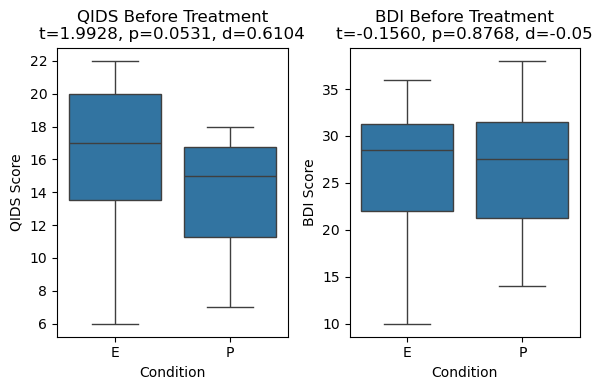

In [6]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot QIDS boxplot
sns.boxplot(data=df, x='Condition', y='QIDS_Before', ax=ax1)
ax1.set_xlabel('Condition')
ax1.set_ylabel('QIDS Score')

# QIDS t-test
qids_e = df[df['Condition']=='E']['QIDS_Before']
qids_p = df[df['Condition']=='P']['QIDS_Before']
t_qids, p_qids = stats.ttest_ind(qids_e, qids_p)
d_qids = (qids_e.mean() - qids_p.mean()) / np.sqrt((qids_e.var() + qids_p.var()) / 2)

# Collect STD values for QIDS
qids_std_e = qids_e.std()
qids_std_p = qids_p.std()

ax1.set_title(f'QIDS Before Treatment\nt={t_qids:.4f}, p={p_qids:.4f}, d={d_qids:.4f}')

# Plot BDI boxplot  
sns.boxplot(data=df, x='Condition', y='BDI_Before', ax=ax2)
ax2.set_xlabel('Condition')
ax2.set_ylabel('BDI Score')

# BDI t-test
bdi_e = df[df['Condition']=='E']['BDI_Before']
bdi_p = df[df['Condition']=='P']['BDI_Before']
t_bdi, p_bdi = stats.ttest_ind(bdi_e, bdi_p)
d_bdi = (bdi_e.mean() - bdi_p.mean()) / np.sqrt((bdi_e.var() + bdi_p.var()) / 2)

# Collect STD values for BDI
bdi_std_e = bdi_e.std()
bdi_std_p = bdi_p.std()

ax2.set_title(f'BDI Before Treatment\nt={t_bdi:.4f}, p={p_bdi:.4f}, d={d_bdi:.2f}')

plt.tight_layout() 

# Print stds as a table
std_table = pd.DataFrame({
    "Escitalopram": [qids_std_e, bdi_std_e],
    "Psilocybin": [qids_std_p, bdi_std_p]
}, index=["QIDS std", "BDI std"])
print("Standard Deviations:")
print(std_table.to_string(float_format="%.2f"))

Standard Deviations:
          Escitalopram  Psilocybin
QIDS std          6.30        4.80
BDI std          10.55        8.06


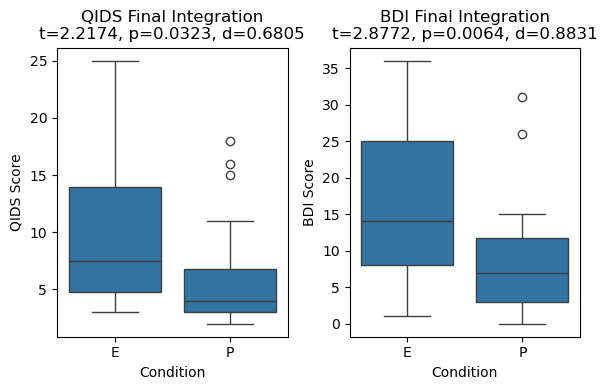

In [7]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot QIDS boxplot
sns.boxplot(data=df, x='Condition', y='QIDS_Final_Integration', ax=ax1)
ax1.set_xlabel('Condition')
ax1.set_ylabel('QIDS Score')

# QIDS t-test
qids_e = df[df['Condition']=='E']['QIDS_Final_Integration']
qids_p = df[df['Condition']=='P']['QIDS_Final_Integration']
t_qids, p_qids = stats.ttest_ind(qids_e, qids_p)
d_qids = (qids_e.mean() - qids_p.mean()) / np.sqrt((qids_e.var() + qids_p.var()) / 2)

ax1.set_title(f'QIDS Final Integration\nt={t_qids:.4f}, p={p_qids:.4f}, d={d_qids:.4f}')

# Plot BDI boxplot  
sns.boxplot(data=df, x='Condition', y='BDI_Final_Integration', ax=ax2)
ax2.set_xlabel('Condition')
ax2.set_ylabel('BDI Score')

# BDI t-test
bdi_e = df[df['Condition']=='E']['BDI_Final_Integration']
bdi_p = df[df['Condition']=='P']['BDI_Final_Integration']
t_bdi, p_bdi = stats.ttest_ind(bdi_e, bdi_p)
d_bdi = (bdi_e.mean() - bdi_p.mean()) / np.sqrt((bdi_e.var() + bdi_p.var()) / 2)

ax2.set_title(f'BDI Final Integration\nt={t_bdi:.4f}, p={p_bdi:.4f}, d={d_bdi:.4f}')

plt.tight_layout()

# Compute stds and print as a table
qids_std_e = qids_e.std()
qids_std_p = qids_p.std()
bdi_std_e = bdi_e.std()
bdi_std_p = bdi_p.std()

std_table = pd.DataFrame({
    "Escitalopram": [qids_std_e, bdi_std_e],
    "Psilocybin": [qids_std_p, bdi_std_p]
}, index=["QIDS std", "BDI std"])
print("Standard Deviations:")
print(std_table.to_string(float_format="%.2f"))

Standard Deviations:
          Escitalopram  Psilocybin
QIDS std          5.48        5.77
BDI std           8.49       10.64


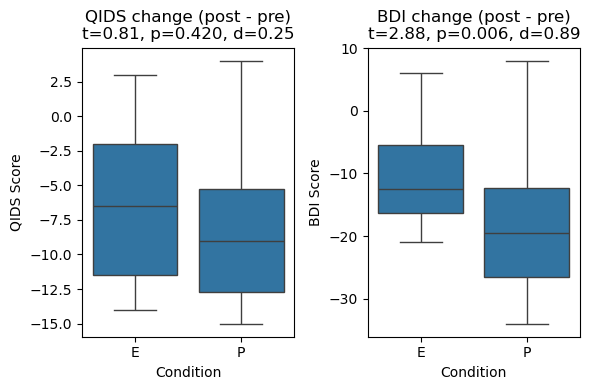

In [8]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot QIDS boxplot
sns.boxplot(data=df, x='Condition', y='Delta_QIDS', ax=ax1)
ax1.set_xlabel('Condition')
ax1.set_ylabel('QIDS Score')

# QIDS t-test
qids_e = df[df['Condition']=='E']['Delta_QIDS']
qids_p = df[df['Condition']=='P']['Delta_QIDS']
t_qids, p_qids = stats.ttest_ind(qids_e, qids_p)
d_qids = (qids_e.mean() - qids_p.mean()) / np.sqrt((qids_e.var() + qids_p.var()) / 2)

ax1.set_title(f'QIDS change (post - pre)\nt={t_qids:.2f}, p={p_qids:.3f}, d={d_qids:.2f}')

# Plot BDI boxplot  
sns.boxplot(data=df, x='Condition', y='Delta_BDI', ax=ax2)
ax2.set_xlabel('Condition')
ax2.set_ylabel('BDI Score')

# BDI t-test
bdi_e = df[df['Condition']=='E']['Delta_BDI']
bdi_p = df[df['Condition']=='P']['Delta_BDI']
t_bdi, p_bdi = stats.ttest_ind(bdi_e, bdi_p)
d_bdi = (bdi_e.mean() - bdi_p.mean()) / np.sqrt((bdi_e.var() + bdi_p.var()) / 2)

ax2.set_title(f'BDI change (post - pre)\nt={t_bdi:.2f}, p={p_bdi:.3f}, d={d_bdi:.2f}')

plt.tight_layout()
 
# Compute stds and print as a table
qids_std_e = qids_e.std()
qids_std_p = qids_p.std()
bdi_std_e = bdi_e.std()
bdi_std_p = bdi_p.std()

std_table = pd.DataFrame({
    "Escitalopram": [qids_std_e, bdi_std_e],
    "Psilocybin": [qids_std_p, bdi_std_p]
}, index=["QIDS std", "BDI std"])
print("Standard Deviations:")
print(std_table.to_string(float_format="%.2f"))

In [9]:
# Create contingency table of Stop_SSRI vs Condition
contingency = pd.crosstab(df['Condition'], df['Stop_SSRI'])
print("Contingency table of Stop_SSRI vs Condition:")
print(contingency)
print()

# Perform chi-square test
chi2, p_value = stats.chi2_contingency(contingency)[:2]

# Print results
print(f"Chi-square test results:")
print(f"chi2 = {chi2:.3f}")
print(f"p-value = {p_value:.3f}")

Contingency table of Stop_SSRI vs Condition:
Stop_SSRI   0   1
Condition        
E          13   7
P          12  10

Chi-square test results:
chi2 = 0.140
p-value = 0.708


---
# Main Figures

## Fig. 2: Prediction Performance of graphTRIP

In [10]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.2')
os.makedirs(fig_subdir, exist_ok=True)

#### a. graphTRIP and Linear Regression Benchmark Performance

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/weights/prediction_results.csv. Loading existing results.


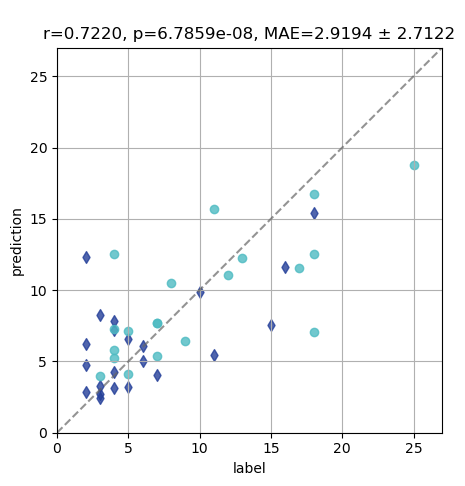

In [11]:
# Load prediction results
results_file = os.path.join(weights_base_dir, 'prediction_results.csv')
results = aggregate_prediction_results(results_file=results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphTRIP_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/ablation/linreg_on_clinical_data/prediction_results.csv. Loading existing results.


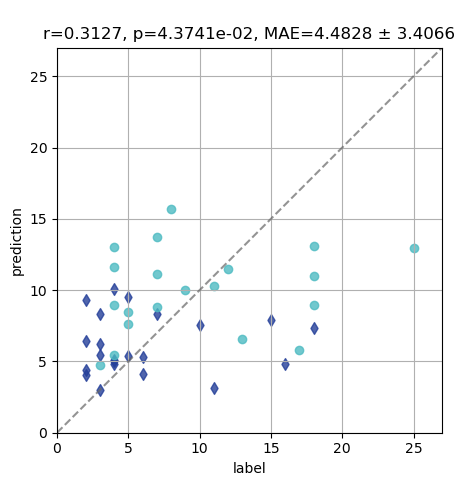

In [12]:
# Clinical data only performance
results_file = os.path.join(output_dir, 'ablation', 'linreg_on_clinical_data', 'prediction_results.csv')
results = aggregate_prediction_results(results_file=results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, 'linreg_on_clinical_data_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### b. graphTRIP and control MLP partial correlations
Performance after controlling for treatment.

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/weights/prediction_results.csv. Loading existing results.
True group means:
   escitalopram: 9.95
   psilocybin: 6.136363636363637

MLP predicted group means:
   escitalopram: 9.470399049520493
   psilocybin: 6.371452421491796


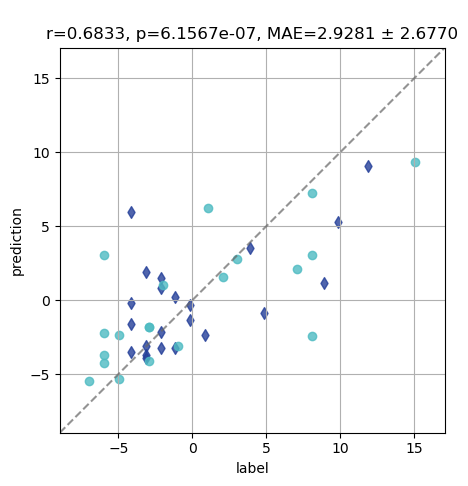

In [13]:
# graphTRIP
results_file = os.path.join(weights_base_dir, 'prediction_results.csv')
results = aggregate_prediction_results(results_file=results_file)

# Compute true mean QIDS for each drug condition
escitalopram_mean = results[results['Condition'] == -1.0]['label'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['label'].mean()
print("True group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
print()

# Subtract the true mean for each group
results.loc[results['Condition'] == -1.0, 'label'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'label'] -= psilocybin_mean

# Subtract the predicted group mean for MLP
escitalopram_mean = results[results['Condition'] == -1.0]['prediction'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['prediction'].mean()
print("MLP predicted group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
results.loc[results['Condition'] == -1.0, 'prediction'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'prediction'] -= psilocybin_mean

# Plot the true vs predicted scatter
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphtrip_partial_corr.svg')
true_vs_pred_scatter(results, save_path=save_path)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/ablation/linreg_on_clinical_data/prediction_results.csv. Loading existing results.
True group means:
   escitalopram: 9.95
   psilocybin: 6.136363636363637

Linear regression predicted group means:
   escitalopram: 9.97118346
   psilocybin: 6.155018656363636


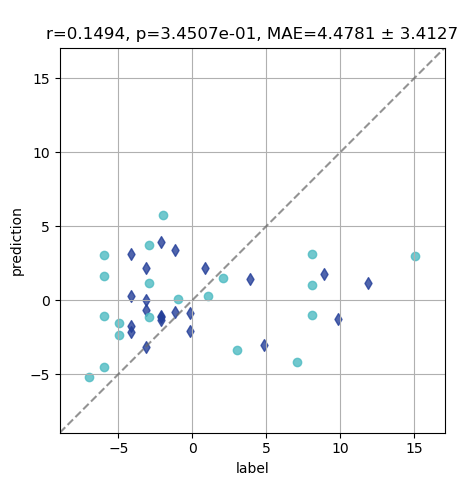

In [14]:
# Control MLP
results_file = os.path.join(output_dir, 'ablation', 'linreg_on_clinical_data', 'prediction_results.csv')
results = aggregate_prediction_results(results_file=results_file)

# Compute true mean QIDS for each drug condition
escitalopram_mean = results[results['Condition'] == -1.0]['label'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['label'].mean()
print("True group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
print()

# Subtract the true mean for each group
results.loc[results['Condition'] == -1.0, 'label'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'label'] -= psilocybin_mean

# Subtract the predicted group mean for MLP
escitalopram_mean = results[results['Condition'] == -1.0]['prediction'].mean()
psilocybin_mean = results[results['Condition'] == 1.0]['prediction'].mean()
print("Linear regression predicted group means:")
print(f'   escitalopram: {escitalopram_mean}')
print(f'   psilocybin: {psilocybin_mean}')
results.loc[results['Condition'] == -1.0, 'prediction'] -= escitalopram_mean
results.loc[results['Condition'] == 1.0, 'prediction'] -= psilocybin_mean

# Plot the true vs predicted scatter
save_path = None if not save_figs else os.path.join(fig_subdir, 'linreg_on_clinical_data_partial_corr.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### c-d. VGAE reconstruction performance

In [15]:
# Get mean test reconstructions across seeds
mean_adj_orig_rcn, mean_x_orig_rcn = get_mean_test_reconstructions(vgaes_dict, data, test_indices_dict=test_indices_dict)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(mean_adj_orig_rcn)
mean_x_orig_rcn['metrics'] = evaluate_x_reconstructions(mean_x_orig_rcn)
mean_x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

In [16]:
# Plotting settings
sub = 0 # example subject
vrange = (-0.7, 0.7)
cmap = COOLWARM

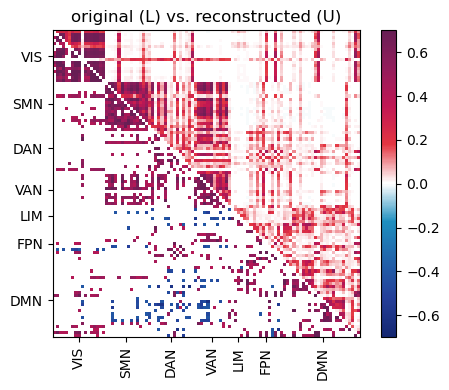

In [17]:
# Plot FC reconstructions
save_path = None if not save_figs else os.path.join(fig_subdir, f'fc_reconstruction_sub{sub}.svg')
plot_fc_reconstruction_single(mean_adj_orig_rcn, 
                              rsn_mapping=rsn_mapping, 
                              rsn_labels=rsn_names, 
                              subject_idx=sub,
                              cmap=cmap, 
                              vrange=vrange,
                              save_path=save_path)

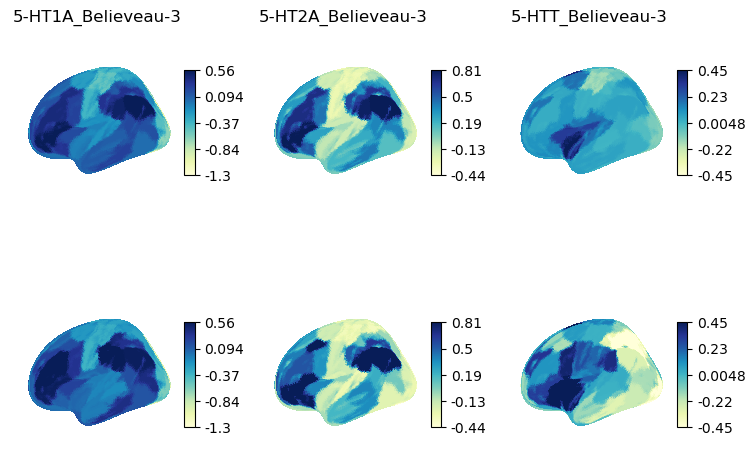

In [18]:
save_path = None if not save_figs else os.path.join(fig_subdir, f'x_reconstructions_sub{sub}.png')
reconstructed = mean_x_orig_rcn['reconstructed'][:, :, sub]
original = mean_x_orig_rcn['original'][:, :, sub]
data2plot = np.stack([reconstructed, original], axis=0)
plot_brain_surface_grid(data2plot, 
                        atlas=data.atlas, 
                        view='medial',
                        cmap=x_cmaps,
                        column_names=mean_x_orig_rcn['feature_names'],
                        save_path=save_path);

# Save regional values in brain_surface dir
if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, 'graphTRIP_reconstructions')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    reconstructed_df = pd.DataFrame(reconstructed, columns=mean_x_orig_rcn['feature_names'])
    original_df = pd.DataFrame(original, columns=mean_x_orig_rcn['feature_names'])
    reconstructed_df.to_csv(os.path.join(brain_surface_subdir, f'reconstructed_sub{sub}.csv'), index=False)
    original_df.to_csv(os.path.join(brain_surface_subdir, f'original_sub{sub}.csv'), index=False)

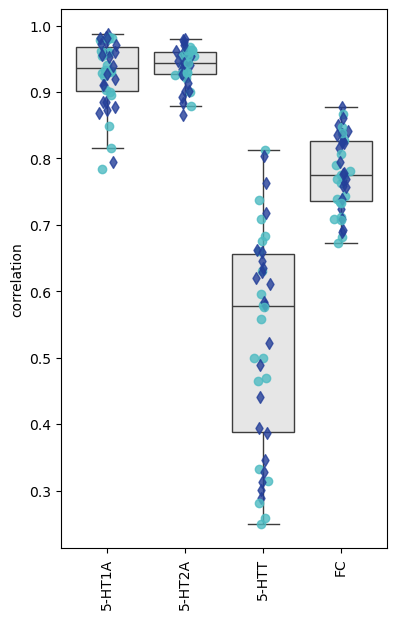

In [19]:
# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'original_vs_reconstructed_corrs.svg')
plot_metric_boxplot(mean_x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

#### e. Permutation importance

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/permutation_importance/importance_scores_aggregated.csv. Loading existing results.


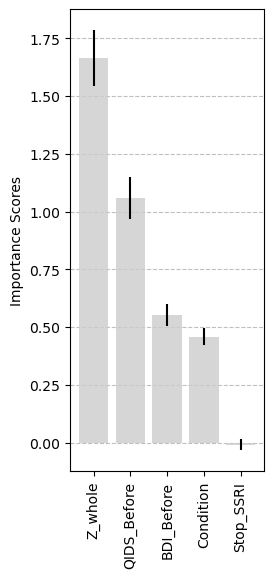

In [20]:
# Permutation Importance
results_file = os.path.join(output_dir, 'graphtrip', 'permutation_importance', 'importance_scores_aggregated.csv')
results = aggregate_importance_scores(results_file)

# Sort the rows of results by mean importance score
results = results.sort_values(by='mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'importance_scores_aggregated.svg')
permutation_importance_bar_chart(results, yerr_column='se', color=NEUTRAL, alpha=0.8, save_path=save_path)

## Fig. 3: Generalisation across brain atlases

In [21]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.3')
os.makedirs(fig_subdir, exist_ok=True)

#### a. Transfer to Schaefer 200

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/transfer_atlas/schaefer200/initial_prediction_results.csv. Loading existing results.


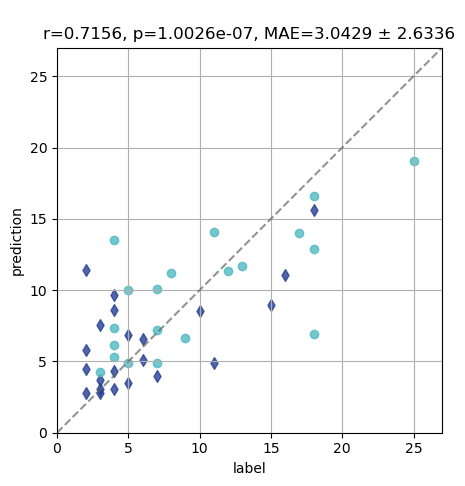

In [22]:
# Schaefer 200
atlas = 'schaefer200'
results_file = os.path.join(output_dir, 'graphtrip', 'transfer_atlas', atlas, 'initial_prediction_results.csv')
results = aggregate_prediction_results(results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, f'true_vs_pred_{atlas}.svg')
true_vs_pred_scatter(results, save_path=save_path)

In [23]:
# Load Schaefer 200 data
atlas = 'schaefer200'
results_dir = os.path.join(output_dir, 'graphtrip', 'transfer_atlas', atlas)
atlas_config = load_ingredient_configs(os.path.join(results_dir, 'seed_0'), ingredients=['dataset'])
atlas_data = load_dataset(atlas_config['dataset'])

# Get new rsn_mapping for Schaefer 200
atlas_rsn_mapping, atlas_rsn_labels = get_rsn_mapping(atlas)

Loading model configurations.


In [24]:
# Get reconstructions from the new data, using the same VGAEs and test fold indices as the original model
mean_adj_orig_rcn, mean_x_orig_rcn = get_mean_test_reconstructions(vgaes_dict, atlas_data, test_indices_dict=test_indices_dict)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(mean_adj_orig_rcn)
mean_x_orig_rcn['metrics'] = evaluate_x_reconstructions(mean_x_orig_rcn)
mean_x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

In [25]:
# Plotting settings
sub = 0 # example subject
vrange = (-0.7, 0.7)
cmap = COOLWARM

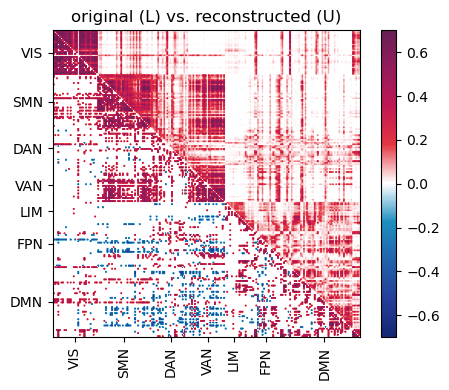

In [26]:
# Plot FC reconstructions
save_path = None if not save_figs else os.path.join(fig_subdir, f'fc_reconstruction_sub{sub}_{atlas}.svg')
plot_fc_reconstruction_single(mean_adj_orig_rcn, 
                            rsn_mapping=atlas_rsn_mapping, 
                            rsn_labels=atlas_rsn_labels, 
                            subject_idx=sub,
                            cmap=cmap, 
                            vrange=vrange,
                            save_path=save_path)

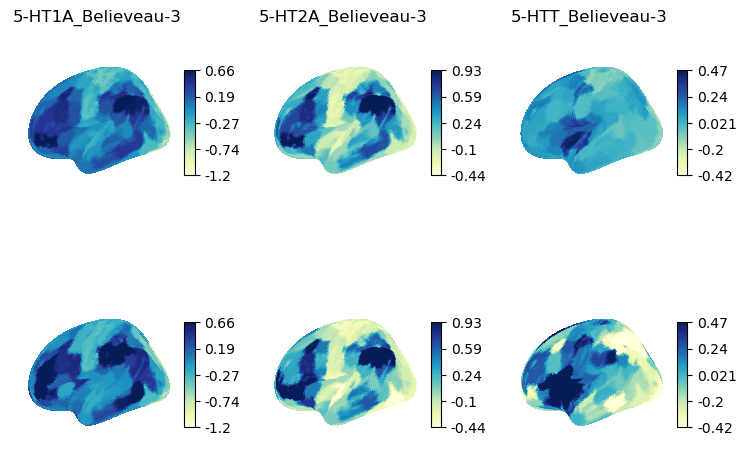

In [27]:
save_path = None if not save_figs else os.path.join(fig_subdir, f'x_reconstructions_sub{sub}.png')
reconstructed = mean_x_orig_rcn['reconstructed'][:, :, sub]
original = mean_x_orig_rcn['original'][:, :, sub]
data2plot = np.stack([reconstructed, original], axis=0)
plot_brain_surface_grid(data2plot, 
                        atlas=atlas_data.atlas, 
                        view='medial',
                        cmap=x_cmaps,
                        column_names=mean_x_orig_rcn['feature_names'],
                        save_path=save_path);

# Save regional values in brain_surface dir
if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, f'graphTRIP_reconstructions_{atlas}')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    reconstructed_df = pd.DataFrame(reconstructed, columns=mean_x_orig_rcn['feature_names'])
    original_df = pd.DataFrame(original, columns=mean_x_orig_rcn['feature_names'])
    reconstructed_df.to_csv(os.path.join(brain_surface_subdir, f'reconstructed_sub{sub}.csv'), index=False)
    original_df.to_csv(os.path.join(brain_surface_subdir, f'original_sub{sub}.csv'), index=False)

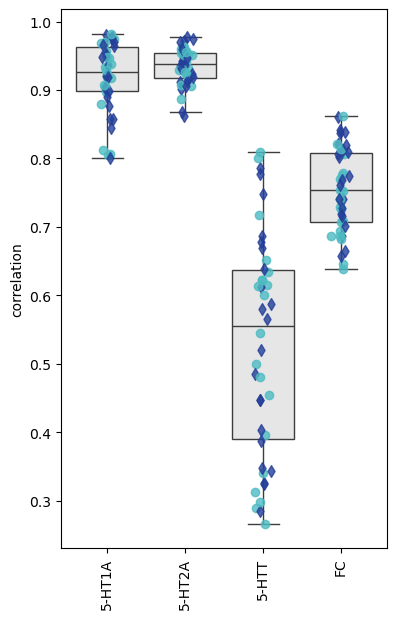

In [28]:
# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, f'original_vs_reconstructed_corrs_{atlas}.svg')
plot_metric_boxplot(mean_x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

## Fig. 4: Generalisation to an independent dataset

In [29]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.4')
os.makedirs(fig_subdir, exist_ok=True)
results_base_dir = os.path.join(output_dir, 'validation', 'finetuning')

#### b. Reconstruction performance of graphTRIP VGAE (not fine-tuned)

In [30]:
# Load Psildeop1 validation dataset
config_dir = os.path.join(results_base_dir, 'seed_0')
psilodep1_config = load_ingredient_configs(config_dir, ingredients=['dataset'])
psilodep1_data = load_dataset(psilodep1_config['dataset'])
psilodep1_num_subs = len(psilodep1_data)
psilodep1_conditions = np.ones(psilodep1_num_subs) # all patients were treated with psilocybin
num_nodes, num_node_attrs = psilodep1_data[0].x.shape

Loading model configurations.


In [31]:
# Get mean reconstructions for all patients with all VGAEs (from all folds and seeds)
mean_adj_orig_rcn, mean_x_orig_rcn = get_mean_test_reconstructions(vgaes_dict, psilodep1_data, test_indices_dict=None)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(mean_adj_orig_rcn)
mean_x_orig_rcn['metrics'] = evaluate_x_reconstructions(mean_x_orig_rcn)
mean_x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

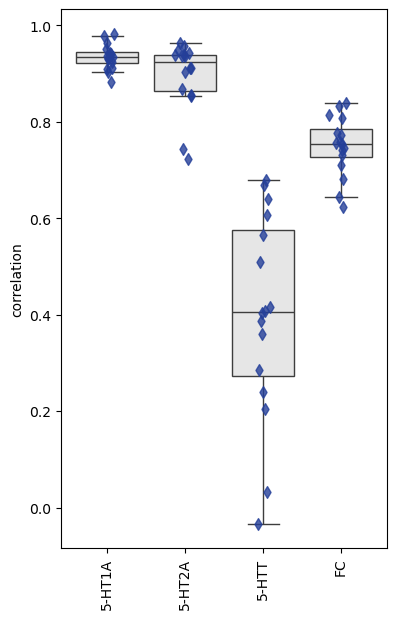

In [32]:
# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'original_vs_reconstructed_corrs.svg')
plot_metric_boxplot(mean_x_orig_rcn['metrics']['corr'], 
                    conditions=psilodep1_conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

#### c. Prediction performance after finetuning

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/validation/finetuning/prediction_results_mean_vote.csv. Loading existing results.


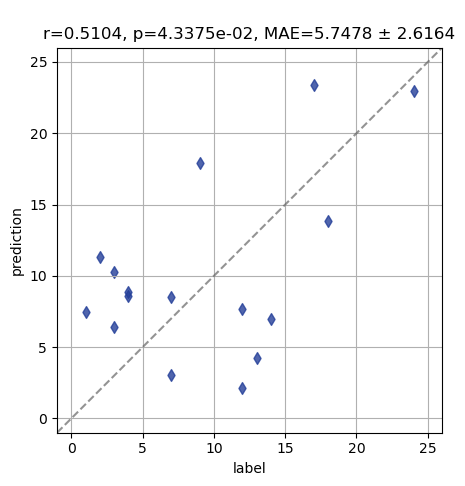

In [33]:
# Load prediction results
results_file = os.path.join(results_base_dir, 'prediction_results_mean_vote.csv')
results = aggregate_prediction_results(results_file=results_file)
results['Condition'] = 1 # add psilocybin condition for plotting
save_path = None if not save_figs else os.path.join(fig_subdir, 'finetuned_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### d. The effect of pretraining

In [34]:
base_dir = os.path.join(output_dir, 'validation')
subdir_names = [
    'control_mlp', 
    'linreg_on_clinical_data', 
    'psilodep1_graphtrip', 
    'finetuning']

all_model_metrics_dfs = []
for subdir_name in subdir_names:
    subdir_path = os.path.join(base_dir, subdir_name)
    if not os.path.exists(subdir_path):
        continue
    seed_dirs = [d for d in os.listdir(subdir_path) if d.startswith('seed_') and os.path.isdir(os.path.join(subdir_path, d))]
    for seed_dir in seed_dirs:
        # Determine correct metrics file name
        if subdir_name == 'evaluate_graphtrip':
            metrics_path = os.path.join(subdir_path, seed_dir, 'initial_metrics_mean_vote.csv')
        elif subdir_name == 'finetuning':
            metrics_path = os.path.join(subdir_path, seed_dir, 'final_metrics_mean_vote.csv')
        else:
            metrics_path = os.path.join(subdir_path, seed_dir, 'final_metrics.csv')
        if os.path.exists(metrics_path):
            df = pd.read_csv(metrics_path)
            df['model'] = subdir_name
            all_model_metrics_dfs.append(df)
all_model_metrics_df = pd.concat(all_model_metrics_dfs, ignore_index=True)

Minimum significant r-value: 0.49730903545923993


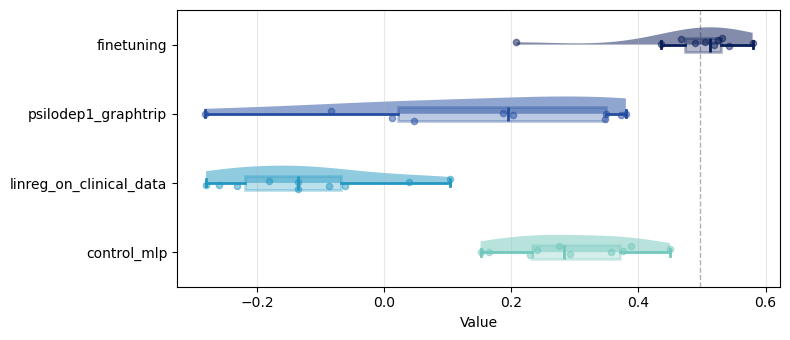

In [35]:
# Get the minimum significant r-value
r_min = min_significant_r(psilodep1_num_subs)
print(f'Minimum significant r-value: {r_min}')

# Create dictionary of distributions by model type
distributions = {
    model: all_model_metrics_df[all_model_metrics_df['model'] == model]['r'].tolist()
    for model in all_model_metrics_df['model'].unique()}

# Plot distributions as raincloud plot
offset = 2
colors = plot_colormap_stack('YlGnBu', len(distributions)+offset, make_plot=False)
colors = colors[offset:]
palette = {name: color for name, color in zip(distributions.keys(), colors)}
save_path = None if not save_figs else os.path.join(fig_subdir, 'raincloud_retrained_vs_pretrained.svg')
plot_raincloud(distributions, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.5, 
               box_alpha=0.3,
               vline=r_min, 
               sort_by_mean=False, 
               figsize=(8, 3.5))

In [36]:
# Assess performance differences between fine-tuned models and others
global_df, posthoc_df = compare_model_performances(distributions, is_dependent=True, model_of_interest="finetuning")

print("Global Effect")
print(global_df.to_string(index=False))
print("\nPairwise Comparisons")
print(posthoc_df[(posthoc_df["Model A"] == "finetuning") | (posthoc_df["Model B"] == "finetuning")].to_string(index=False))
print()

# Print the mean and sem "r" values for each model
for model in all_model_metrics_df['model'].unique():
    model_df = all_model_metrics_df[all_model_metrics_df['model'] == model]
    mean_r = model_df['r'].mean()
    sem_r = model_df['r'].sem()
    print(f"{model}: mean r = {mean_r:.3f}, sem r = {sem_r:.3f}")

# Save results
if save_figs:
    global_df.to_csv(os.path.join(fig_subdir, 'global_effect.csv'), index=False)
    posthoc_df.to_csv(os.path.join(fig_subdir, 'pairwise_comparisons.csv'), index=False)


Global Effect
         Test  Statistic  P-Value  Significant (alpha=0.05)
Friedman Test      22.44 0.000053                      True

Pairwise Comparisons
                Model A    Model B  Original P-Value  Corrected P-Value  Reject Null (Significant Difference)
linreg_on_clinical_data finetuning          0.001953           0.002930                                  True
    psilodep1_graphtrip finetuning          0.001953           0.002930                                  True
            control_mlp finetuning          0.009766           0.009766                                  True

control_mlp: mean r = 0.293, sem r = 0.031
linreg_on_clinical_data: mean r = -0.123, sem r = 0.040
psilodep1_graphtrip: mean r = 0.153, sem r = 0.071
finetuning: mean r = 0.480, sem r = 0.033


## Fig. 5: Estimating Treatment Effects with Medusa graphTRIP

In [37]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.5')
os.makedirs(fig_subdir, exist_ok=True)
results_base_dir = os.path.join(output_dir, 'medusa_graphtrip')

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/medusa_graphtrip/weights/prediction_results.csv. Loading existing results.


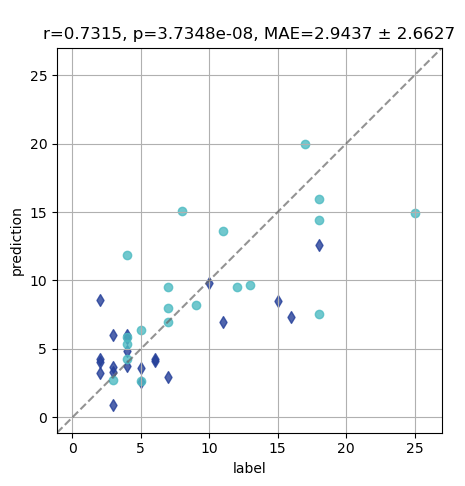

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/medusa_graphtrip/weights/counterfactual_predictions.csv. Loading existing results.


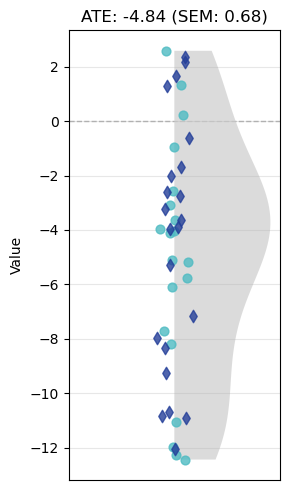

In [38]:
# Load prediction results
results_file = os.path.join(results_base_dir, 'weights', 'prediction_results.csv')
pred_results = aggregate_prediction_results(results_file=results_file)

# Plot pseudo-ITE labels vs predicted ITEs
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_graphtrip_true_vs_pred.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

# Load ITE estimates
results_file = os.path.join(results_base_dir, 'weights', 'counterfactual_predictions.csv')
ite_results = aggregate_prediction_results(results_file=results_file)

# Compute ITEs
ite_results['ITE'] = ite_results['prediction_mlp1'] - ite_results['prediction_mlp0']

# Plot ITE violin
save_path = None if not save_figs else os.path.join(fig_subdir, 'ite_violin.svg')
plot_ite_violin(ite_results, save_path=save_path, ycol='ITE')

## Fig. 6: Interpreting Predictions (Regional Attributions & Biomarkers)

In [39]:
# Define output directory for model performance
fig_subdir = os.path.join(figure_dir, 'Fig.6')
os.makedirs(fig_subdir, exist_ok=True)

#### b. Regional Attributions

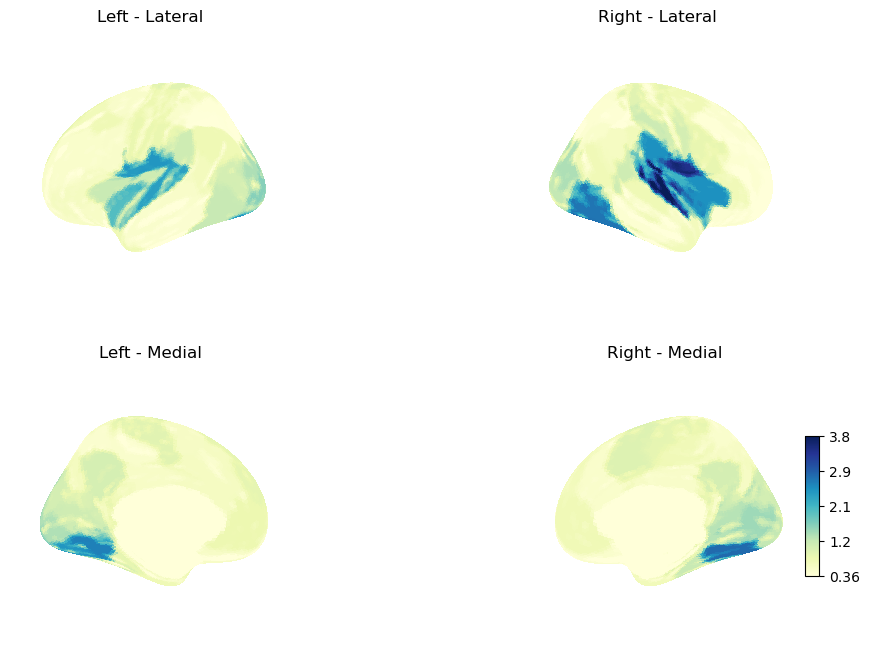

In [40]:
# Load performance-weighted regional gradient weights
results_base_dir = os.path.join(output_dir, 'graphtrip', 'regional_attributions', 'posthoc_analysis')
attributions_df = pd.read_csv(os.path.join(results_base_dir, 'weighted_mean_attributions.csv'))

# Plot mean gradient weights
save_path = None if not save_figs else os.path.join(fig_subdir, 'population_mean_regional_attributions.png')
population_mean = attributions_df.mean(axis=0).values
plot_brain_surface(population_mean, 
                   atlas=data.atlas, 
                   cmap=CMAP_DEFAULT,
                   save_path=save_path);

if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, 'graphtrip_regional_attributions')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    np.savetxt(os.path.join(brain_surface_subdir, 'weighted_mean_regional_attributions.csv'), population_mean)

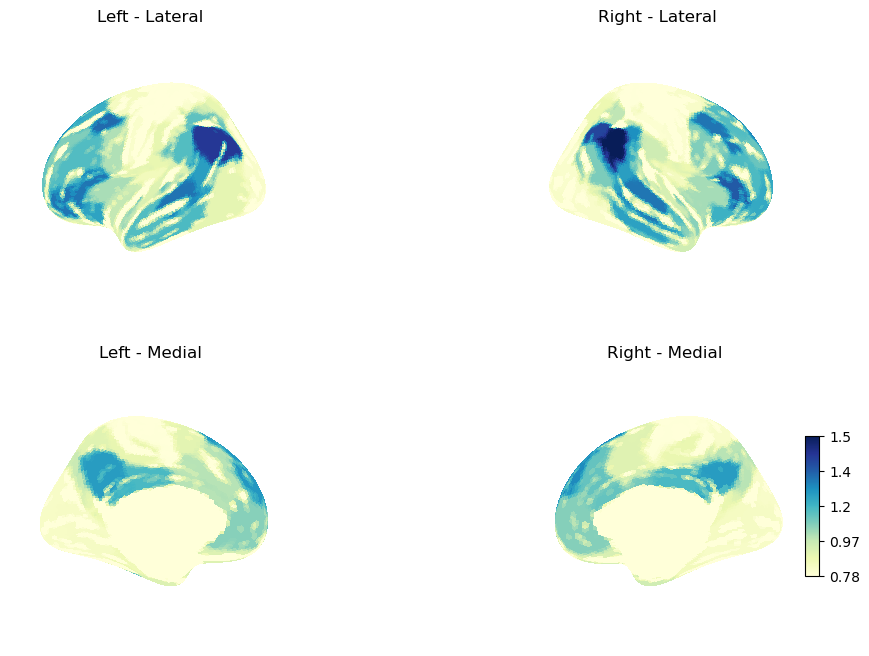

In [41]:
# Load performance-weighted regional gradient weights
results_base_dir = os.path.join(output_dir, 'medusa_graphtrip', 'regional_attributions', 'posthoc_analysis')
attributions_df = pd.read_csv(os.path.join(results_base_dir, 'weighted_mean_attributions.csv'))

# Plot mean gradient weights
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_population_mean_regional_attributions.png')
population_mean = attributions_df.mean(axis=0).values
plot_brain_surface(population_mean, 
                   atlas=data.atlas, 
                   cmap=CMAP_DEFAULT,
                   save_path=save_path);

if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, 'medusa_graphtrip_regional_attributions')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    np.savetxt(os.path.join(brain_surface_subdir, 'weighted_mean_regional_attributions.csv'), population_mean)

#### c. Regional Attributions in Resting-state Networks

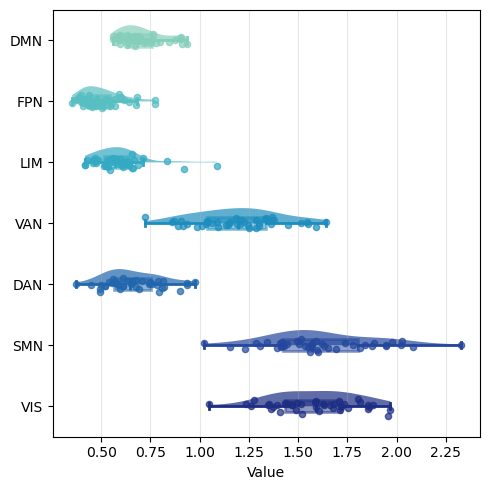

,RSN1,RSN2,tstat,pval,fdr,cohen_d
4,VIS,FPN,26.206161,3.134488e-27,4.851149e-26,6.557879
3,VIS,LIM,25.944912,4.620142e-27,4.851149e-26,5.707602
9,SMN,FPN,21.973158,2.682794e-24,1.877956e-23,5.494366
5,VIS,DMN,20.003374,9.149713e-23,4.803599e-22,5.285998
1,VIS,DAN,19.857284,1.202259e-22,5.049487e-22,5.176968
8,SMN,LIM,19.594881,1.971546e-22,6.900410e-22,4.881063
6,SMN,DAN,18.705050,1.098982e-21,3.296945e-21,4.469644
10,SMN,DMN,17.850855,6.086189e-21,1.597625e-20,4.473630
16,VAN,FPN,17.067748,3.094322e-20,7.220085e-20,4.117126
20,FPN,DMN,-16.686416,6.973344e-20,1.464402e-19,-1.943140


In [42]:
# Load mean RSN attributions
results_base_dir = os.path.join(output_dir, 'graphtrip', 'regional_attributions', 'posthoc_analysis')
rsn_df = pd.read_csv(os.path.join(results_base_dir, 'weighted_mean_rsn_attributions.csv'))
rsn_names = rsn_df.columns
n_rsns = len(rsn_names)

# Turn into dictionary for plotting
rsn_dict = rsn_df.to_dict(orient='list')
# rsn_dict = {k: v for k, v in sorted(rsn_dict.items(), key=lambda item: np.mean(item[1]), reverse=True)}

# Plot the raincloud plot
save_path = None if not save_figs else os.path.join(fig_subdir, 'mean_rsn_attributions_raincloud.svg')
offset = 3
colors = sns.color_palette("YlGnBu_r", n_rsns+offset)
palette = {name: color for name, color in zip(rsn_dict.keys(), colors)}
plot_raincloud(rsn_dict, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.7, 
               box_alpha=0.5,
               figsize=(5, 5),
               sort_by_mean=False)

# Compare each pair of RSNs with a paired t-test
stats_df = {'RSN1': [], 'RSN2': [], 'tstat': [], 'pval': [], 'fdr': [], 'cohen_d': []}
for i, rsn1 in enumerate(rsn_names):
    for rsn2 in rsn_names[i+1:]:

        # Compute stats
        t_stat, p_val = stats.ttest_rel(rsn_dict[rsn1], rsn_dict[rsn2])
        d = (np.mean(rsn_dict[rsn1]) - np.mean(rsn_dict[rsn2])) / \
            np.sqrt((np.std(rsn_dict[rsn1])**2 + np.std(rsn_dict[rsn2])**2) / 2)
        
        # Store results
        stats_df['RSN1'].append(rsn1)
        stats_df['RSN2'].append(rsn2) 
        stats_df['tstat'].append(t_stat)
        stats_df['pval'].append(p_val)
        stats_df['cohen_d'].append(d)

# Convert to dataframe and calculate FDR
stats_df['fdr'] = fdrcorrection(stats_df['pval'])[1]
stats_df = pd.DataFrame(stats_df)
stats_df = stats_df.sort_values('pval')
stats_df

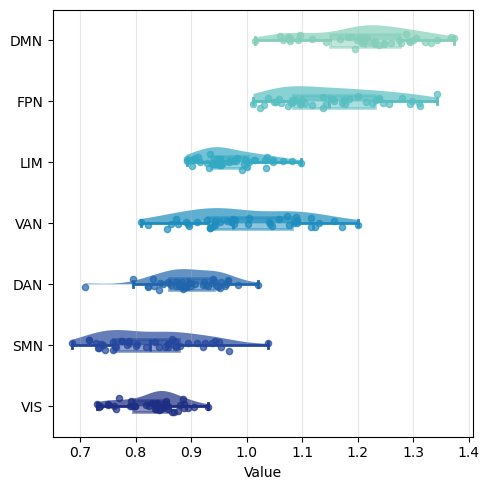

,RSN1,RSN2,tstat,pval,fdr,cohen_d
19,LIM,DMN,-21.074357,1.297631e-23,2.725026e-22,-3.199962
5,VIS,DMN,-20.443191,4.060865e-23,4.263908e-22,-5.189666
4,VIS,FPN,-15.892510,3.961525e-19,2.773068e-18,-4.503893
10,SMN,DMN,-15.638840,6.994149e-19,3.671928e-18,-4.363873
13,DAN,FPN,-14.856396,4.214144e-18,1.769940e-17,-3.432212
14,DAN,DMN,-14.569189,8.283764e-18,2.899317e-17,-4.097405
9,SMN,FPN,-12.849824,5.771393e-16,1.731418e-15,-3.780398
18,LIM,FPN,-12.095881,4.152500e-15,1.090031e-14,-2.512176
3,VIS,LIM,-10.988437,8.590301e-14,2.004404e-13,-2.759917
7,SMN,VAN,-10.179118,8.691861e-13,1.825291e-12,-1.819523


In [43]:
# Load mean RSN attributions
results_base_dir = os.path.join(output_dir, 'medusa_graphtrip', 'regional_attributions', 'posthoc_analysis')
rsn_df = pd.read_csv(os.path.join(results_base_dir, 'weighted_mean_rsn_attributions.csv'))
rsn_names = rsn_df.columns
n_rsns = len(rsn_names)

# Turn into dictionary for plotting
rsn_dict = rsn_df.to_dict(orient='list')
# rsn_dict = {k: v for k, v in sorted(rsn_dict.items(), key=lambda item: np.mean(item[1]), reverse=True)}

# Plot the raincloud plot
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_mean_rsn_attributions_raincloud.svg')
offset = 3
colors = sns.color_palette("YlGnBu_r", n_rsns+offset)
palette = {name: color for name, color in zip(rsn_dict.keys(), colors)}
plot_raincloud(rsn_dict, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.7, 
               box_alpha=0.5,
               figsize=(5, 5),
               sort_by_mean=False)

# Compare each pair of RSNs with a paired t-test
stats_df = {'RSN1': [], 'RSN2': [], 'tstat': [], 'pval': [], 'fdr': [], 'cohen_d': []}
for i, rsn1 in enumerate(rsn_names):
    for rsn2 in rsn_names[i+1:]:

        # Compute stats
        t_stat, p_val = stats.ttest_rel(rsn_dict[rsn1], rsn_dict[rsn2])
        d = (np.mean(rsn_dict[rsn1]) - np.mean(rsn_dict[rsn2])) / \
            np.sqrt((np.std(rsn_dict[rsn1])**2 + np.std(rsn_dict[rsn2])**2) / 2)
        
        # Store results
        stats_df['RSN1'].append(rsn1)
        stats_df['RSN2'].append(rsn2) 
        stats_df['tstat'].append(t_stat)
        stats_df['pval'].append(p_val)
        stats_df['cohen_d'].append(d)

# Convert to dataframe and calculate FDR
stats_df['fdr'] = fdrcorrection(stats_df['pval'])[1]
stats_df = pd.DataFrame(stats_df)
stats_df = stats_df.sort_values('pval')
stats_df

#### d. Dominance Analysis of Regional Attribution Patterns

R2:  0.4297186230805857 p-value:  0.0019980019980019


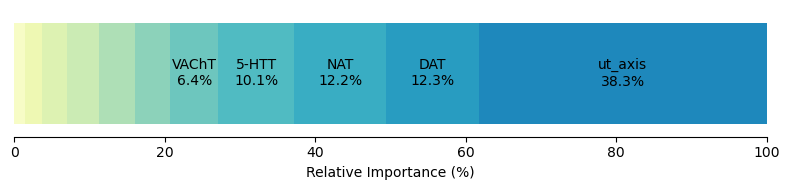

In [44]:
# Plot stacked percentages
results_base_dir = os.path.join(output_dir, 'graphtrip', 'regional_attributions', 'posthoc_analysis')
da_df = pd.read_csv(os.path.join(results_base_dir, 'da_receptors_utaxis_stats.csv'), index_col=0)
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphtrip_dominance_analysis.svg')
offset = 5
palette = sns.color_palette("YlGnBu", len(da_df)+offset)
palette = palette[:-offset]
plot_stacked_percentages(df=da_df,
                         percentage_col='Percentage Relative Importance',
                         save_path=save_path,
                         palette=palette, 
                         figsize=(8, 2))

# Print significance and r-squared of linear model
metrics = pd.read_csv(os.path.join(results_base_dir, 'da_receptors_utaxis_r2_pval_tstat.csv'))
print("R2: ", metrics['r2'].values[0], "p-value: ", metrics['p_value'].values[0])

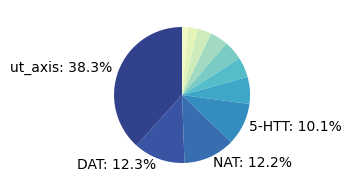

In [45]:
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphtrip_dominance_analysis_piechart.svg')
palette = sns.color_palette("YlGnBu_r", len(da_df))
plot_piechart(df=da_df,
              percentage_col='Percentage Relative Importance',
              save_path=save_path,
              palette=palette, 
              figsize=(8, 2),
              alpha=0.9);

R2:  0.8003848088801606 p-value:  0.0009990009990009


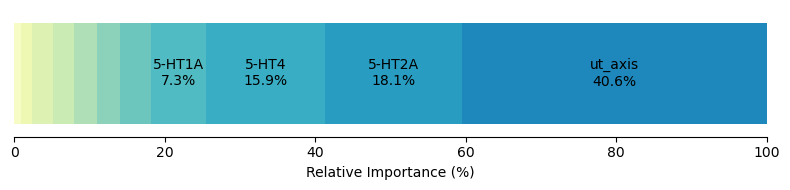

In [46]:
# Plot stacked percentages
results_base_dir = os.path.join(output_dir, 'medusa_graphtrip', 'regional_attributions', 'posthoc_analysis')
da_df = pd.read_csv(os.path.join(results_base_dir, 'da_receptors_utaxis_stats.csv'), index_col=0)
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_dominance_analysis.svg')
offset = 5
palette = sns.color_palette("YlGnBu", len(da_df)+offset)
palette = palette[:-offset]
plot_stacked_percentages(df=da_df,
                         percentage_col='Percentage Relative Importance',
                         save_path=save_path,
                         palette=palette, 
                         figsize=(8, 2))

# Print significance and r-squared of linear model
metrics = pd.read_csv(os.path.join(results_base_dir, 'da_receptors_utaxis_r2_pval_tstat.csv'))
print("R2: ", metrics['r2'].values[0], "p-value: ", metrics['p_value'].values[0])

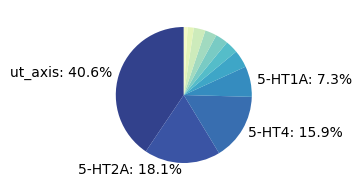

In [47]:
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_dominance_analysis_piechart.svg')
palette = sns.color_palette("YlGnBu_r", len(da_df))
plot_piechart(df=da_df,
              percentage_col='Percentage Relative Importance',
              save_path=save_path,
              palette=palette, 
              figsize=(8, 2),
              alpha=0.9);

#### f. GRAIL biomarker results

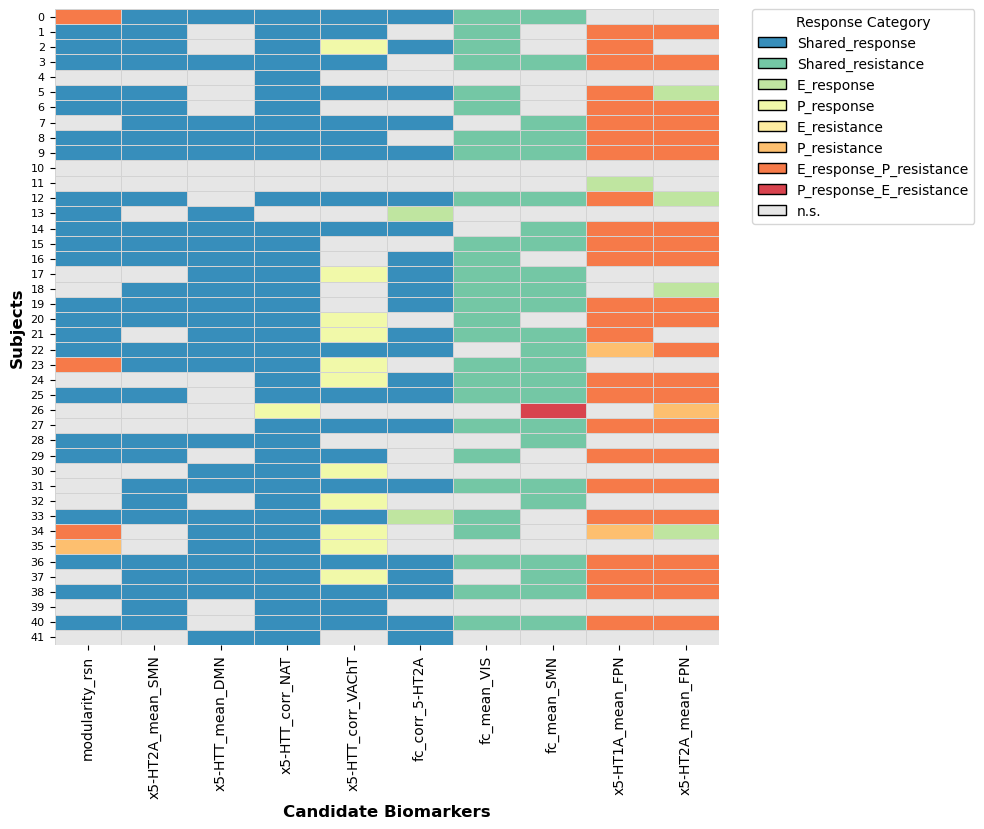

In [48]:
# Make palette for biomarker categories
cats = [
    'Shared_response',
    'Shared_resistance',
    'E_response',
    'P_response',
    'E_resistance',
    'P_resistance',
    'E_response_P_resistance',
    'P_response_E_resistance'
]
colors = sns.color_palette("Spectral_r", len(cats))
palette = {name: color for name, color in zip(cats, colors)}
palette['n.s.'] = (0.9, 0.9, 0.9)

# Load biomarker categories
biomarker_categories = pd.read_csv(os.path.join(project_root(), 'outputs','biomarker_categories', 'biomarker_categories.csv'))

# Count number of 'n.s.' in each column and drop columns with num_ns > int(thresh*num_subs)
thresh = 0.5
num_ns = biomarker_categories.apply(lambda col: col.value_counts().get('n.s.', 0))
biomarker_categories = biomarker_categories.loc[:, num_ns <= int(thresh*len(biomarker_categories))]

# For each biomarker, get the majority (non-'n.s.') category string label
biomarker_names = list(biomarker_categories.columns)
majority_cat = {}
for biomarker in biomarker_names:
    # Exclude 'n.s.' from the value counts
    counts = biomarker_categories[biomarker].value_counts()
    if 'n.s.' in counts:
        counts = counts.drop('n.s.')
    if not counts.empty:
        majority_cat[biomarker] = counts.idxmax()
    else:
        majority_cat[biomarker] = 'n.s.'

# Sort columns by majority category
unique_cats = sorted(list(set(majority_cat.values())), reverse=True)
cat_biomarker_mapping = {cat: [] for cat in unique_cats}
for feat, cat in majority_cat.items():
    cat_biomarker_mapping[cat].append(feat)
sorted_biomarkers = []
for cat in unique_cats:
    sorted_biomarkers.extend(sort_features(cat_biomarker_mapping[cat]))

# Plot the heatmap
plot_biomarker_heatmap(biomarker_categories[sorted_biomarkers], palette)

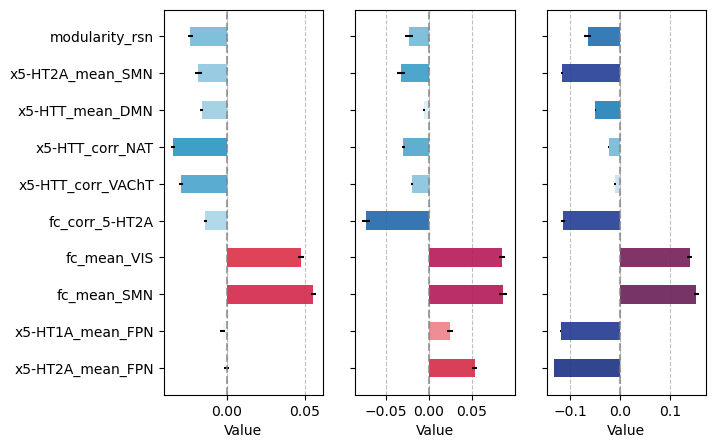

In [49]:
# Load gradient alignment results from graphTRIP core model
grail_dir = os.path.join(output_dir, 'graphtrip', 'grail', 'posthoc_analysis')
graphtrip = pd.read_csv(os.path.join(grail_dir, 'weighted_mean_alignments.csv'))

medusa_grail_dir = os.path.join(output_dir, 'medusa_graphtrip', 'grail', 'posthoc_analysis')
medusa = pd.read_csv(os.path.join(medusa_grail_dir, 'weighted_mean_alignments.csv'))

medusa_grail_dir = os.path.join(output_dir, 'medusa_graphtrip', 'grail_psilocybin', 'posthoc_analysis')
medusa_psilocybin = pd.read_csv(os.path.join(medusa_grail_dir, 'weighted_mean_alignments.csv'))

medusa_grail_dir = os.path.join(output_dir, 'medusa_graphtrip', 'grail_escitalopram', 'posthoc_analysis')
medusa_escitalopram = pd.read_csv(os.path.join(medusa_grail_dir, 'weighted_mean_alignments.csv'))

# Reverse order of sorted_biomarkers
sorted_biomarkers_reversed = sorted_biomarkers[::-1]

# Make a list of dfs
dfs = [graphtrip, medusa_psilocybin, medusa_escitalopram] #, medusa]
dfs = [df[sorted_biomarkers_reversed] for df in dfs]

# Plot
vmax = 0.15
fig_size = (7, 5)
save_path = None if not save_figs else os.path.join(fig_subdir, 'mean_alignments_all_modes.svg')
fig, ax = plot_diverging_bars_multi(dfs, 
                    yline=0, 
                    cmap=COOLWARM, 
                    vmax=vmax, 
                    alpha=0.9,
                    add_scatter=False, 
                    scatter_alpha=0.5, 
                    scatter_size=20,
                    figsize=fig_size,
                    save_path=save_path,
                    bar_orientation='horizontal',
                    bar_width=0.5,
                    add_colorbar=False)

In [50]:
import statsmodels.formula.api as smf

# Load candidate biomarker values for all subjects
results_dir = os.path.join(output_dir, 'graphtrip', 'test_biomarkers')
biomarker_values = pd.read_csv(os.path.join(results_dir, 'feature_values.csv'))

# Add drug condition to df
biomarker_values = biomarker_values.sort_values('sub')
biomarker_values['Condition'] = conditions
biomarker_values = biomarker_values.drop(columns=['sub'])

# Replace hyphens with underscores in all biomarker columns
biomarker_values.columns = [col.replace('-', '_') for col in biomarker_values.columns]

# Define your feature lists AND replace hyphens with underscores in feature names
shared = [name.replace('-', '_') for name in (cat_biomarker_mapping.get('Shared_response', []) + 
                                              cat_biomarker_mapping.get('Shared_resistance', []))]
conditional = [name.replace('-', '_') for name in 
               (cat_biomarker_mapping.get('E_response_P_resistance', []) + 
                cat_biomarker_mapping.get('P_response_E_resistance', []))]

# Construct the formula string
formula = "y ~ " + " + ".join(shared) + " + " + " * Condition + ".join(conditional) + " * Condition"

# Fit the model
model = smf.ols(formula=formula, data=biomarker_values).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     2.594
Date:                Sun, 01 Feb 2026   Prob (F-statistic):             0.0168
Time:                        00:35:52   Log-Likelihood:                -116.51
No. Observations:                  42   AIC:                             261.0
Df Residuals:                      28   BIC:                             285.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

---
# Supplementary

In [51]:
# Define output directory for supplementary
sm_figure_dir = os.path.join(figure_dir, 'SUPPLEMENTARY')
os.makedirs(sm_figure_dir, exist_ok=True)

## Benchmarks (PCA, t-SNE, MLP, VGAE + Linear Regression Head)

In [52]:
# Define output directory for model performance
fig_subdir = os.path.join(sm_figure_dir, 'benchmarks')
os.makedirs(fig_subdir, exist_ok=True)

#### VGAE + Linear Regression Head

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/ablation/vgae_linreg_head/prediction_results.csv. Loading existing results.


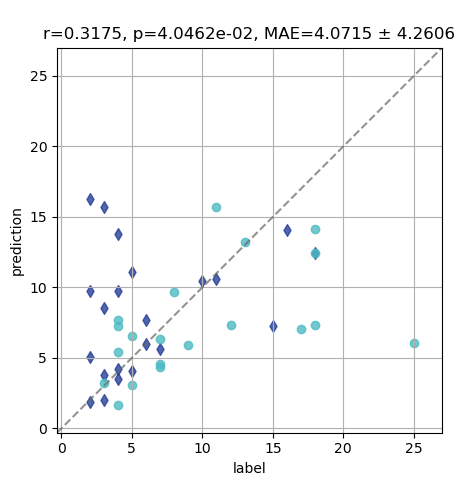

In [53]:
# Load prediction results
results_file = os.path.join(output_dir, 'ablation', 'vgae_linreg_head', 'prediction_results.csv')
pred_results = aggregate_prediction_results(results_file=results_file)

# Plot true vs predicted values
save_path = None if not save_figs else os.path.join(fig_subdir, 'vgae_with_linreg_head_true_vs_predicted.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

#### MLP, Trained on Clinical Data

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/ablation/control_mlp/prediction_results.csv. Loading existing results.


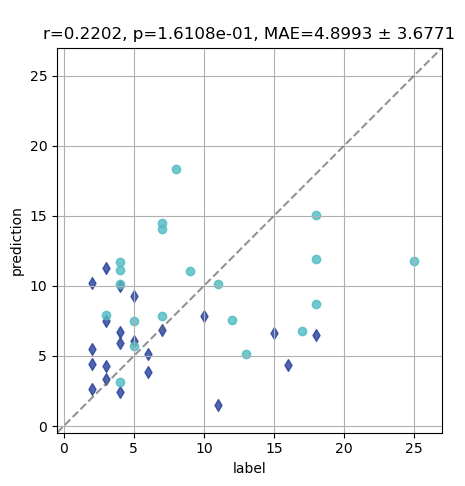

In [54]:
# Load prediction results
results_file = os.path.join(output_dir, 'ablation', 'control_mlp', 'prediction_results.csv')
pred_results = aggregate_prediction_results(results_file=results_file)

# Plot true vs predicted values
save_path = None if not save_figs else os.path.join(fig_subdir, 'control_mlp_true_vs_predicted.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

#### PCA benchmark

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/ablation/pca_benchmark/prediction_results.csv. Loading existing results.


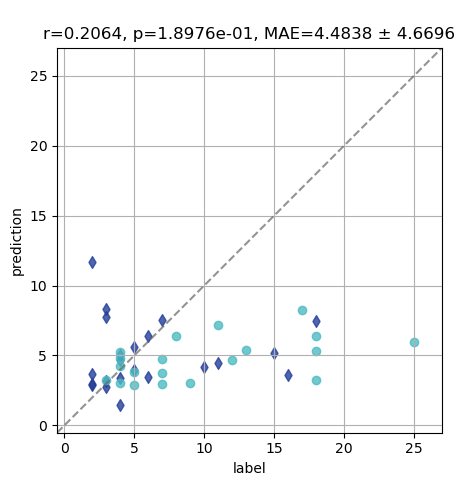

In [55]:
# Load prediction results
results_file = os.path.join(output_dir, 'ablation', 'pca_benchmark', 'prediction_results.csv')
pred_results = aggregate_prediction_results(results_file=results_file)

save_path = None if not save_figs else os.path.join(fig_subdir, 'pca_true_vs_predicted.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

#### t-SNE benchmark

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/ablation/tsne_benchmark/prediction_results.csv. Loading existing results.


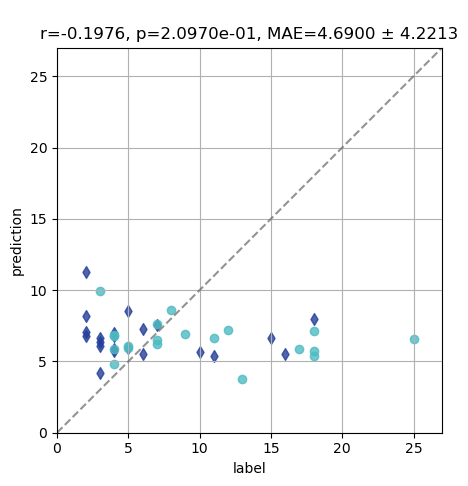

In [56]:
# Load prediction results
results_file = os.path.join(output_dir, 'ablation', 'tsne_benchmark', 'prediction_results.csv')
pred_results = aggregate_prediction_results(results_file=results_file)

save_path = None if not save_figs else os.path.join(fig_subdir, 'tsne_true_vs_predicted.svg')
true_vs_pred_scatter(pred_results, save_path=save_path)

#### Random Seed Sensitivity

In [57]:
ablation_base_dir = os.path.join(output_dir, 'ablation')
graphtrip_base_dir = os.path.join(output_dir, 'graphtrip')
subdir_names = [
    'weights',                 # graphtrip core model
    'control_mlp',             # MLP trained on clinical data
    'vgae_linreg_head',        # VGAE with linear regression head
    'linreg_on_clinical_data', # Linear regression model trained on clinical data
    'pca_benchmark',           # MLP trained on PCA-reduced neuroimaging data + clinical data
    'tsne_benchmark'           # MLP trained on t-SNE-reduced neuroimaging data + clinical data
]

all_model_metrics_dfs = []
for subdir_name in subdir_names:
    if subdir_name == 'weights':
        subdir_path = os.path.join(graphtrip_base_dir, subdir_name)
    else:
        subdir_path = os.path.join(ablation_base_dir, subdir_name)
    if not os.path.exists(subdir_path):
        raise ValueError(f'Subdirectory {subdir_path} does not exist')
    seed_dirs = [d for d in os.listdir(subdir_path) if d.startswith('seed_') and os.path.isdir(os.path.join(subdir_path, d))]
    for seed_dir in seed_dirs:
        metrics_path = os.path.join(subdir_path, seed_dir, 'final_metrics.csv')
        if os.path.exists(metrics_path):
            df = pd.read_csv(metrics_path)
            if subdir_name == 'weights':
                df['model'] = 'graphtrip'
            else:
                df['model'] = subdir_name
            all_model_metrics_dfs.append(df)
        else:
            print(f'Warning: Metrics file {metrics_path} does not exist')
all_model_metrics_df = pd.concat(all_model_metrics_dfs, ignore_index=True)

Minimum significant r-value: 0.30439558028623787


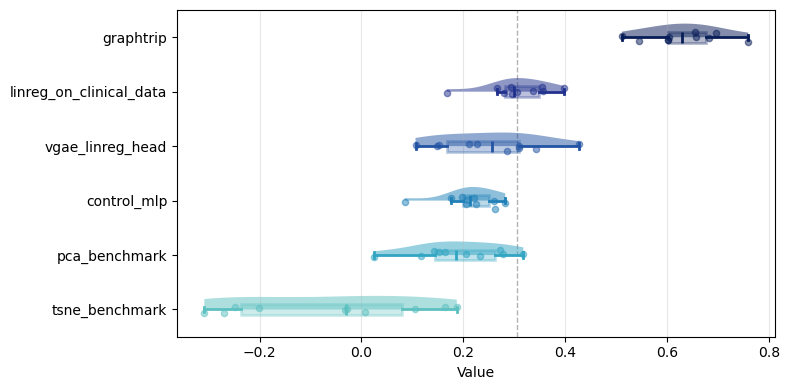

In [58]:
# Get the minimum significant r-value
r_min = min_significant_r(num_subs)
print(f'Minimum significant r-value: {r_min}')

# Create dictionary of distributions by model type
distributions = {
    model: all_model_metrics_df[all_model_metrics_df['model'] == model]['r'].tolist()
    for model in all_model_metrics_df['model'].unique()}

# Sort by mean r-value
distributions = dict(sorted(distributions.items(), key=lambda x: np.mean(x[1])))

# Plot distributions as raincloud plot
offset = 4
colors = plot_colormap_stack('YlGnBu', len(distributions)+offset, make_plot=False)
colors = colors[offset:]
palette = {name: color for name, color in zip(distributions.keys(), colors)}
save_path = None if not save_figs else os.path.join(fig_subdir, 'raincloud_graphtrip_vs_benchmarks.svg')
plot_raincloud(distributions, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.5, 
               box_alpha=0.3,
               vline=r_min, 
               sort_by_mean=False, 
               figsize=(8, 4))

In [59]:
# Assess performance differences between fine-tuned models and others
global_df, posthoc_df = compare_model_performances(distributions, is_dependent=True, model_of_interest="graphtrip")

print("Global Effect")
print(global_df.to_string(index=False))
print("\nPairwise Comparisons")
print(posthoc_df[(posthoc_df["Model A"] == "graphtrip") | (posthoc_df["Model B"] == "graphtrip")].to_string(index=False))
print()

# Print the mean and sem "r" values for each model
for model in all_model_metrics_df['model'].unique():
    model_df = all_model_metrics_df[all_model_metrics_df['model'] == model]
    mean_r = model_df['r'].mean()
    sem_r = model_df['r'].sem()
    print(f"{model}: mean r = {mean_r:.3f}, sem r = {sem_r:.3f}")

# Save results
if save_figs:
    global_df.to_csv(os.path.join(fig_subdir, 'global_effect.csv'), index=False)
    posthoc_df.to_csv(os.path.join(fig_subdir, 'pairwise_comparisons.csv'), index=False)


Global Effect
         Test  Statistic      P-Value  Significant (alpha=0.05)
Friedman Test  38.971429 2.406492e-07                      True

Pairwise Comparisons
                Model A   Model B  Original P-Value  Corrected P-Value  Reject Null (Significant Difference)
         tsne_benchmark graphtrip          0.001953           0.001953                                  True
          pca_benchmark graphtrip          0.001953           0.001953                                  True
            control_mlp graphtrip          0.001953           0.001953                                  True
       vgae_linreg_head graphtrip          0.001953           0.001953                                  True
linreg_on_clinical_data graphtrip          0.001953           0.001953                                  True

graphtrip: mean r = 0.631, sem r = 0.023
control_mlp: mean r = 0.212, sem r = 0.018
vgae_linreg_head: mean r = 0.252, sem r = 0.032
linreg_on_clinical_data: mean r = 0.305, sem r = 

## Predicting post-treatment BDI

In [60]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'graphtrip_bdi')
os.makedirs(fig_subdir, exist_ok=True)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip_bdi/weights/prediction_results.csv. Loading existing results.


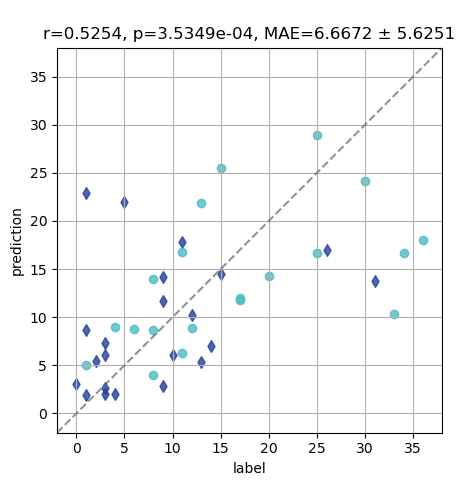

In [61]:
# BDI prediction results
results_file = os.path.join(output_dir, 'graphtrip_bdi', 'weights', 'prediction_results.csv')
results = aggregate_prediction_results(results_file=results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, 'true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

In [62]:
# Load BDI dataset
bdi_weights_base_dir = os.path.join(output_dir, 'graphtrip_bdi', 'weights')
bdi_test_indices_dict, bdi_weights_dirs = load_test_fold_indices(bdi_weights_base_dir, subdir_name_pattern='seed_*')
bdi_config = load_ingredient_configs(bdi_weights_dirs[0], ingredients=['dataset', 'vgae_model'])
bdi_data = load_dataset(bdi_config['dataset'])
bdi_conditions = np.array(get_conditions(bdi_data, bdi_config['dataset']['graph_attrs']))

# Load trained VGAEs
bdi_vgaes_dict = {}
for seed, bdi_weights_dir in enumerate(weights_dirs):
    vgaes = load_vgaes(bdi_config['vgae_model'], bdi_weights_dir, weight_filenames['vgae'])
    bdi_vgaes_dict[f'seed_{seed}'] = vgaes

Loading model configurations.


In [63]:
# Get mean test reconstructions across seeds
mean_adj_orig_rcn, mean_x_orig_rcn = get_mean_test_reconstructions(bdi_vgaes_dict, bdi_data, bdi_test_indices_dict)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(mean_adj_orig_rcn)
mean_x_orig_rcn['metrics'] = evaluate_x_reconstructions(mean_x_orig_rcn)
mean_x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

In [64]:
# Plotting settings
sub = 0 # example subject
vrange = (-0.7, 0.7)
cmap = COOLWARM

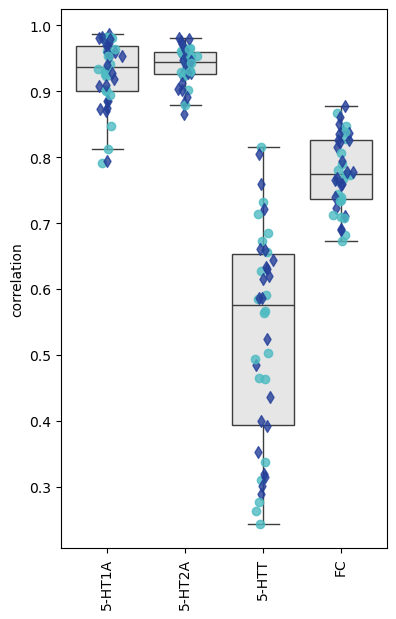

In [65]:
# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'original_vs_recon_corrs.svg')
plot_metric_boxplot(mean_x_orig_rcn['metrics']['corr'], 
                    conditions=bdi_conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip_bdi/permutation_importance/importance_scores_aggregated.csv. Loading existing results.


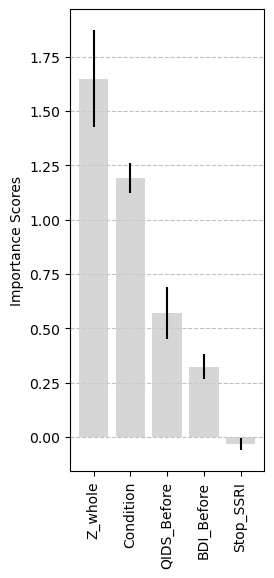

In [66]:
# Permutation Importance
results_file = os.path.join(output_dir, 'graphtrip_bdi', 'permutation_importance', 'importance_scores_aggregated.csv')
results = aggregate_importance_scores(results_file)

# Sort the rows of results by mean importance score
results = results.sort_values(by='mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'importance_scores_aggregated.svg')
permutation_importance_bar_chart(results, yerr_column='se', color=NEUTRAL, alpha=0.8, save_path=save_path)

## Generalisation to AAL brain atlas

In [67]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'aal_atlas')
os.makedirs(fig_subdir, exist_ok=True)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/transfer_atlas/aal/initial_prediction_results.csv. Loading existing results.


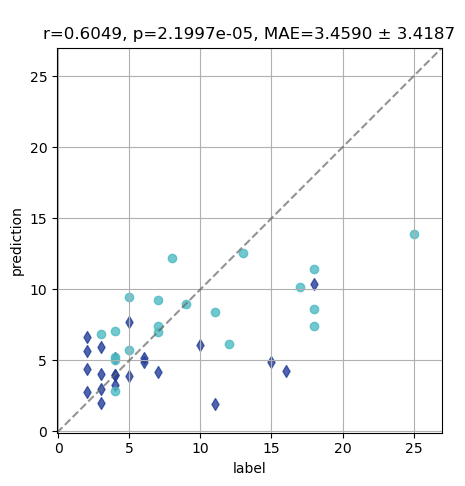

In [68]:
# AAL 116 atlas
atlas = 'aal'
results_file = os.path.join(output_dir, 'graphtrip', 'transfer_atlas', atlas, 'initial_prediction_results.csv')
results = aggregate_prediction_results(results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, f'true_vs_pred_{atlas}.svg')
true_vs_pred_scatter(results, save_path=save_path)

In [69]:
# Load AAL 116 data
atlas = 'aal'
results_dir = os.path.join(output_dir, 'graphtrip', 'transfer_atlas', atlas)
atlas_config = load_ingredient_configs(os.path.join(results_dir, 'seed_0'), ingredients=['dataset'])
atlas_data = load_dataset(atlas_config['dataset'])

# Get new rsn_mapping for Schaefer 200
atlas_rsn_mapping, atlas_rsn_labels = get_rsn_mapping(atlas)

Loading model configurations.


In [70]:
# Get reconstructions from the new data, using the same VGAEs and test fold indices as the original model
mean_adj_orig_rcn, mean_x_orig_rcn = get_mean_test_reconstructions(vgaes_dict, atlas_data, test_indices_dict)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(mean_adj_orig_rcn)
mean_x_orig_rcn['metrics'] = evaluate_x_reconstructions(mean_x_orig_rcn)
mean_x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

In [71]:
# Plotting settings
sub = 0 # example subject
vrange = (-0.7, 0.7)
cmap = COOLWARM

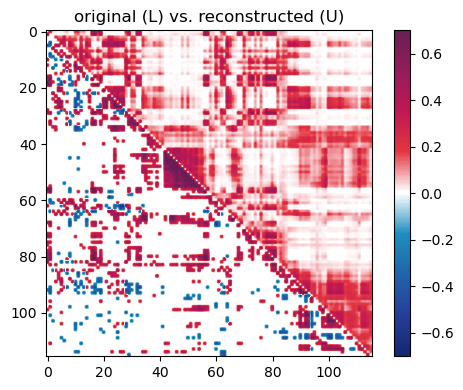

In [72]:
# Plot FC reconstructions
save_path = None if not save_figs else os.path.join(fig_subdir, f'fc_reconstruction_sub{sub}_{atlas}.svg')
plot_fc_reconstruction_single(mean_adj_orig_rcn, 
                            rsn_mapping=atlas_rsn_mapping, 
                            rsn_labels=atlas_rsn_labels, 
                            subject_idx=sub,
                            cmap=cmap, 
                            vrange=vrange,
                            save_path=save_path)

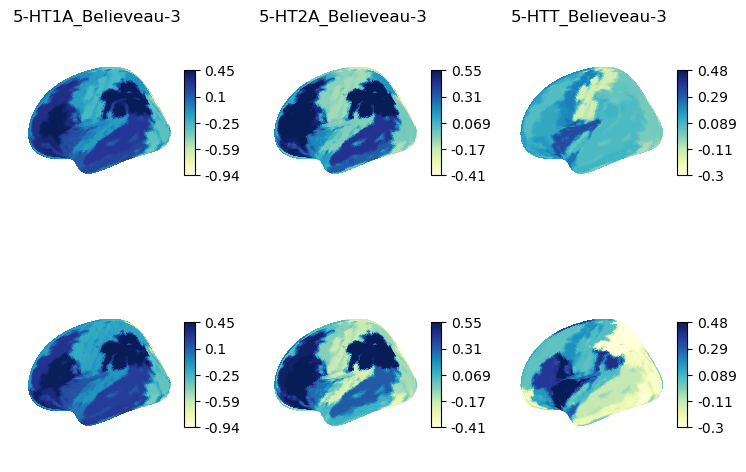

In [73]:
save_path = None if not save_figs else os.path.join(fig_subdir, f'x_reconstructions_sub{sub}.png')
reconstructed = mean_x_orig_rcn['reconstructed'][:, :, sub]
original = mean_x_orig_rcn['original'][:, :, sub]
data2plot = np.stack([reconstructed, original], axis=0)
plot_brain_surface_grid(data2plot, 
                        atlas=atlas_data.atlas, 
                        view='medial',
                        cmap=x_cmaps,
                        column_names=mean_x_orig_rcn['feature_names'],
                        save_path=save_path);

# Save regional values in brain_surface dir
if save_figs:
    brain_surface_subdir = os.path.join(brain_surface_dir, f'graphTRIP_reconstructions_{atlas}')
    os.makedirs(brain_surface_subdir, exist_ok=True)
    reconstructed_df = pd.DataFrame(reconstructed, columns=mean_x_orig_rcn['feature_names'])
    original_df = pd.DataFrame(original, columns=mean_x_orig_rcn['feature_names'])
    reconstructed_df.to_csv(os.path.join(brain_surface_subdir, f'reconstructed_sub{sub}.csv'), index=False)
    original_df.to_csv(os.path.join(brain_surface_subdir, f'original_sub{sub}.csv'), index=False)

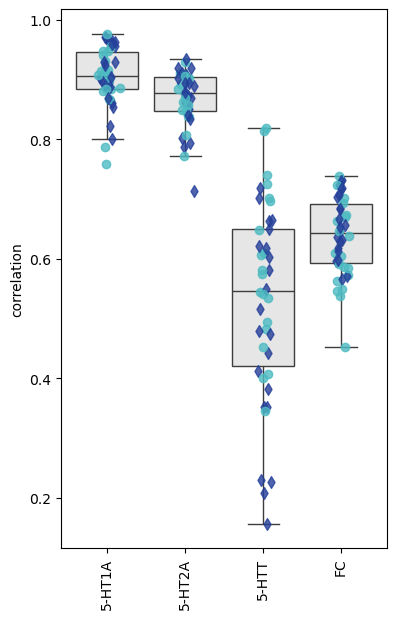

In [74]:
# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, f'original_vs_reconstructed_corrs_{atlas}.svg')
plot_metric_boxplot(mean_x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

In [75]:
from preprocessing.metrics import get_atlas
aal_atlas = get_atlas('aal')

# Full list of AAL116 region labels
aal_region_labels = aal_atlas['labels']

# Define subcortical keywords
subcortical_keywords = [
    'Caudate', 'Putamen', 'Pallidum', 'Thalamus', 'Amygdala',
    'Hippocampus', 'ParaHippocampal',
    'Cerebelum', 'Vermis']

# Classify indices and labels
cortical_labels = []
subcortical_labels = []
cortical_indices = []
subcortical_indices = []

for idx, label in enumerate(aal_region_labels):
    if any(sub in label for sub in subcortical_keywords):
        subcortical_labels.append(label)
        subcortical_indices.append(idx)
    else:
        cortical_labels.append(label)
        cortical_indices.append(idx)

# Convert to numpy arrays
cortical_indices = np.array(cortical_indices)
subcortical_indices = np.array(subcortical_indices)

# Output check
print(f"Number of cortical regions: {len(cortical_labels)}")
print(f"Number of subcortical regions: {len(subcortical_labels)}")

Number of cortical regions: 76
Number of subcortical regions: 40


In [76]:
# Initialize lists to store correlations
node_attr_cortical_corrs = {feat: [] for feat in node_attrs}    
node_attr_subcortical_corrs = {feat: [] for feat in node_attrs}  
fc_cortical_corrs = []
fc_subcortical_corrs = []

# For each subject
for subj in range(num_subs):
    # Get original and reconstructed node attributes for this subject
    x_orig = mean_x_orig_rcn['original'][:,:,subj]
    x_rcn = mean_x_orig_rcn['reconstructed'][:,:,subj]
    
    # Get original and reconstructed FC matrices for this subject
    fc_orig = mean_adj_orig_rcn['original'][:,:,subj]
    fc_rcn = mean_adj_orig_rcn['reconstructed'][:,:,subj]
    
    # Compute node attribute correlations for each feature separately
    for feat_idx, feat_name in enumerate(node_attrs):
        # Cortical regions
        cortical_corr = np.corrcoef(x_orig[cortical_indices,feat_idx], 
                                   x_rcn[cortical_indices,feat_idx])[0,1]
        node_attr_cortical_corrs[feat_name].append(cortical_corr)
        
        # Subcortical regions
        subcortical_corr = np.corrcoef(x_orig[subcortical_indices,feat_idx],
                                      x_rcn[subcortical_indices,feat_idx])[0,1]
        node_attr_subcortical_corrs[feat_name].append(subcortical_corr)
    
    # Get all FC values for cortical regions and compute single correlation
    fc_orig_cortical = fc_orig[cortical_indices,:][:,cortical_indices].flatten()
    fc_rcn_cortical = fc_rcn[cortical_indices,:][:,cortical_indices].flatten()
    fc_cortical_corrs.append(np.corrcoef(fc_orig_cortical, fc_rcn_cortical)[0,1])
    
    # Get all FC values for subcortical regions and compute single correlation
    fc_orig_subcortical = fc_orig[subcortical_indices,:][:,subcortical_indices].flatten()
    fc_rcn_subcortical = fc_rcn[subcortical_indices,:][:,subcortical_indices].flatten()
    fc_subcortical_corrs.append(np.corrcoef(fc_orig_subcortical, fc_rcn_subcortical)[0,1])

# Create dataframe with all correlations
df_dict = {}
for feat_name in node_attrs:
    df_dict[f'cortical_{feat_name}'] = node_attr_cortical_corrs[feat_name]
    df_dict[f'subcortical_{feat_name}'] = node_attr_subcortical_corrs[feat_name]
df_dict['fc_cortical'] = fc_cortical_corrs
df_dict['fc_subcortical'] = fc_subcortical_corrs

results_df = pd.DataFrame(df_dict)

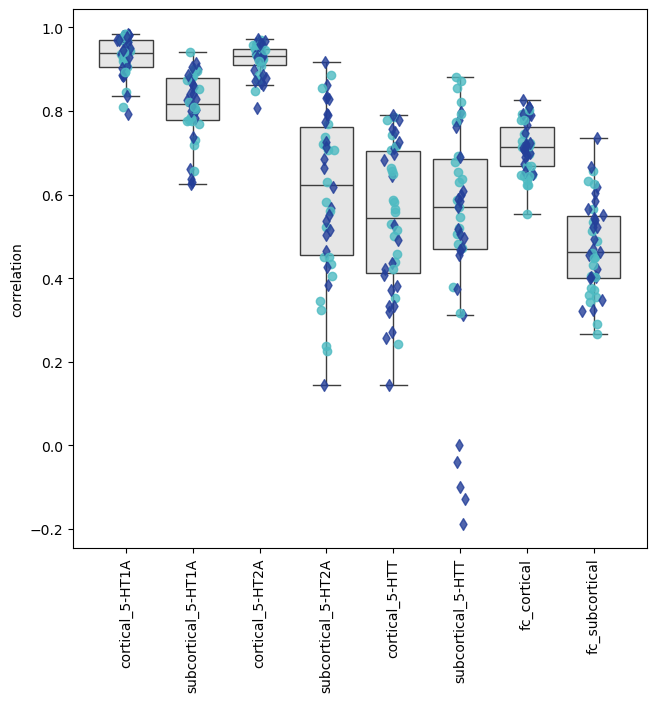

In [77]:
save_path = None if not save_figs else os.path.join(fig_subdir, 'AAL_cortical_vs_subcortical_reconstructions.svg')
plot_metric_boxplot(results_df, 
                    conditions=conditions, 
                    short_names=False, 
                    ylabel='correlation', 
                    save_path=save_path);

## graphTRIP transfer to Psilodep1

In [78]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'evaluate_graphtrip_on_psilodep1')
os.makedirs(fig_subdir, exist_ok=True)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/validation/evaluate_graphtrip/initial_prediction_results_mean_vote.csv. Loading existing results.


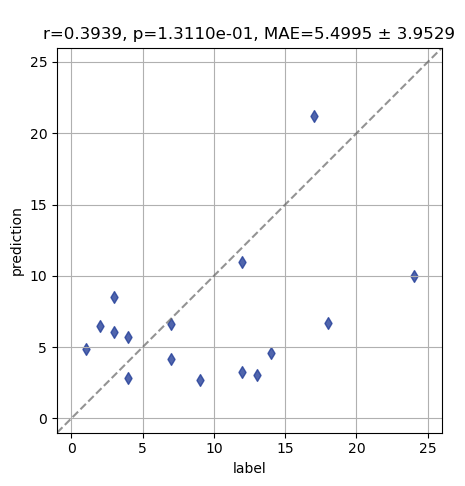

In [79]:
# Load prediction results
results_dir = os.path.join(output_dir, 'validation', 'evaluate_graphtrip')
results_file = os.path.join(results_dir, 'initial_prediction_results_mean_vote.csv')
results = aggregate_prediction_results(results_file=results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, 'initial_mean_vote_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

Minimum significant r-value: 0.49730903545923993


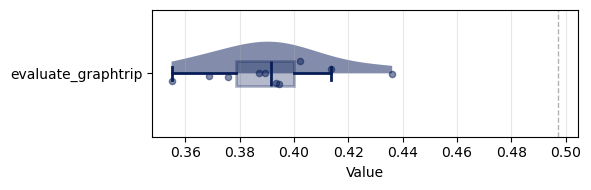

In [80]:
base_dir = os.path.join(output_dir, 'validation')
subdir_names = ['evaluate_graphtrip']

all_model_metrics_dfs = []
for subdir_name in subdir_names:
    subdir_path = os.path.join(base_dir, subdir_name)
    if not os.path.exists(subdir_path):
        continue
    seed_dirs = [d for d in os.listdir(subdir_path) if d.startswith('seed_') and os.path.isdir(os.path.join(subdir_path, d))]
    for seed_dir in seed_dirs:
        # Determine correct metrics file name
        if subdir_name == 'evaluate_graphtrip':
            metrics_path = os.path.join(subdir_path, seed_dir, 'initial_metrics_mean_vote.csv')
        elif subdir_name == 'finetuning':
            metrics_path = os.path.join(subdir_path, seed_dir, 'final_metrics_mean_vote.csv')
        else:
            metrics_path = os.path.join(subdir_path, seed_dir, 'final_metrics.csv')
        if os.path.exists(metrics_path):
            df = pd.read_csv(metrics_path)
            df['model'] = subdir_name
            all_model_metrics_dfs.append(df)
all_model_metrics_df = pd.concat(all_model_metrics_dfs, ignore_index=True)

# Get the minimum significant r-value
psilodep1_num_subs = 16
r_min = min_significant_r(psilodep1_num_subs)
print(f'Minimum significant r-value: {r_min}')

# Create dictionary of distributions by model type
distributions = {
    model: all_model_metrics_df[all_model_metrics_df['model'] == model]['r'].tolist()
    for model in all_model_metrics_df['model'].unique()}

# Plot distributions as raincloud plot
offset = 2
colors = plot_colormap_stack('YlGnBu', len(distributions)+offset, make_plot=False)
colors = colors[offset:]
palette = {name: color for name, color in zip(distributions.keys(), colors)}
save_path = None if not save_figs else os.path.join(fig_subdir, 'raincloud_evaluate_graphtrip_on_psilodep1.svg')
plot_raincloud(distributions, 
               palette=palette, 
               save_path=save_path, 
               alpha=0.5, 
               box_alpha=0.3,
               vline=r_min, 
               sort_by_mean=False, 
               figsize=(6, 2))

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/validation/pretraining/prediction_results.csv. Loading existing results.


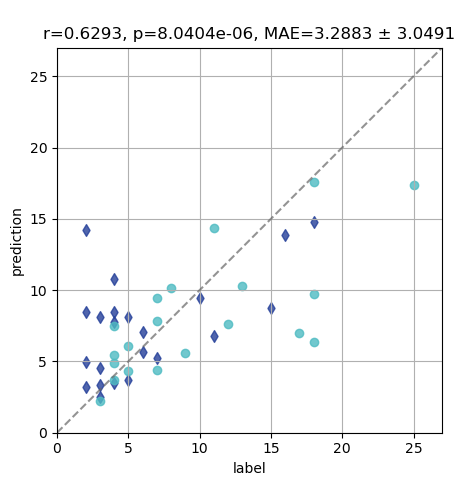

In [81]:
# Load MLP pretraining prediction results
results_dir = os.path.join(output_dir, 'validation', 'pretraining')
results_file = os.path.join(results_dir, 'prediction_results.csv')
results = aggregate_prediction_results(results_file=results_file)
save_path = None if not save_figs else os.path.join(fig_subdir, 'MLP_pretraining_true_vs_pred.svg')
true_vs_pred_scatter(results, save_path=save_path)

## graphTRIP Counterfactual Estimates

In [82]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'graphtrip_counterfactuals')
os.makedirs(fig_subdir, exist_ok=True)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/predictions_psilocybin/initial_prediction_results.csv. Loading existing results.
Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/graphtrip/predictions_escitalopram/initial_prediction_results.csv. Loading existing results.


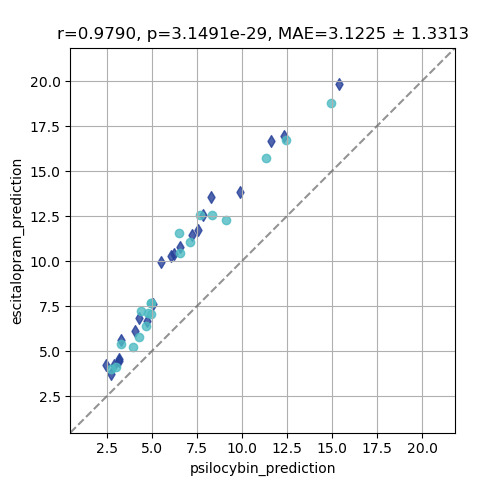

In [83]:
# Load psilocybin counterfactual predictions
results_file = os.path.join(output_dir, 'graphtrip', 'predictions_psilocybin', 'initial_prediction_results.csv')
psilo_results = aggregate_prediction_results(results_file=results_file)

# Load escitalopram counterfactual predictions
results_file = os.path.join(output_dir, 'graphtrip', 'predictions_escitalopram', 'initial_prediction_results.csv')
escit_results = aggregate_prediction_results(results_file=results_file)

# Combine results
combined_df = psilo_results.copy()
combined_df = combined_df.rename(columns={'prediction': 'psilocybin_prediction'})
# Merge the escitalopram predictions using subject_id
combined_df = combined_df.merge(
    escit_results[['subject_id', 'prediction']],
    on='subject_id',
    how='left'
)
combined_df = combined_df.rename(columns={'prediction': 'escitalopram_prediction'})

# Sort by subject_id
combined_df = combined_df.sort_values(by='subject_id')
combined_df['Condition'] = conditions

# Plot escitalopram vs psilocybin predictions
save_path = None if not save_figs else os.path.join(fig_subdir, 'escitalopram_vs_psilocybin_predictions.svg')
true_vs_pred_scatter(combined_df, save_path=save_path, ycol='escitalopram_prediction', xcol='psilocybin_prediction')

## Medusa graphTRIP Reconstruction Performance & Propensities

In [84]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'medusa_reconstructions_and_propensity_estimation')
os.makedirs(fig_subdir, exist_ok=True)

In [85]:
# Load Medusa graphTRIP weights and config
medusa_weights_dir = os.path.join(output_dir, 'medusa_graphtrip', 'weights')
medusa_config = load_ingredient_configs(os.path.join(medusa_weights_dir, 'seed_0'), ingredients=['vgae_model', 'dataset'])
medusa_weight_filenames = get_weight_filenames_from_config(medusa_config)

# Get weights directories and test fold indices for each seed
medusa_test_indices_dict, medusa_weights_dirs = load_test_fold_indices(medusa_weights_dir, subdir_name_pattern='seed_*')
medusa_vgaes_dict = {}
for seed, weights_dir in enumerate(medusa_weights_dirs):
    vgaes = load_vgaes(medusa_config['vgae_model'], weights_dir, medusa_weight_filenames['vgae'])
    medusa_vgaes_dict[f'seed_{seed}'] = vgaes

Loading model configurations.


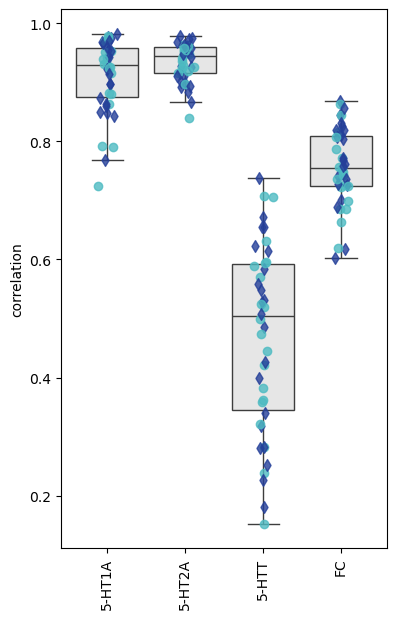

In [86]:
# Get mean test reconstructions across seeds
mean_adj_orig_rcn, mean_x_orig_rcn = get_mean_test_reconstructions(medusa_vgaes_dict, data, test_indices_dict=medusa_test_indices_dict)

# Evaluate FC and x reconstructions
fc_metrics = evaluate_fc_reconstructions(mean_adj_orig_rcn)
mean_x_orig_rcn['metrics'] = evaluate_x_reconstructions(mean_x_orig_rcn)
mean_x_orig_rcn['metrics']['corr']['FC'] = fc_metrics['corr']

# Plot FC and x original-vs-reconstructed correlations together
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_original_vs_reconstructed_corrs.svg')
plot_metric_boxplot(mean_x_orig_rcn['metrics']['corr'], 
                    conditions=conditions, 
                    short_names=True, 
                    ylabel='correlation', 
                    save_path=save_path);

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/medusa_graphtrip/estimate_propensity/prediction_results.csv. Loading existing results.


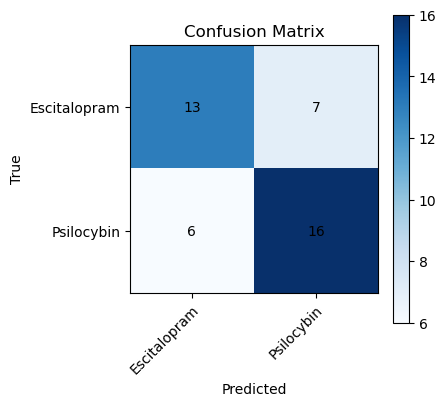

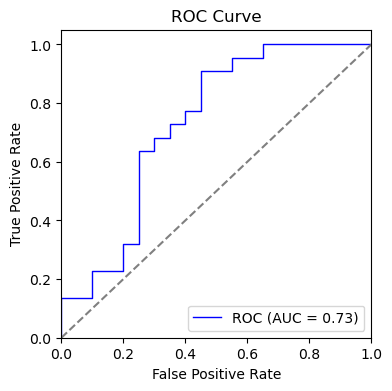

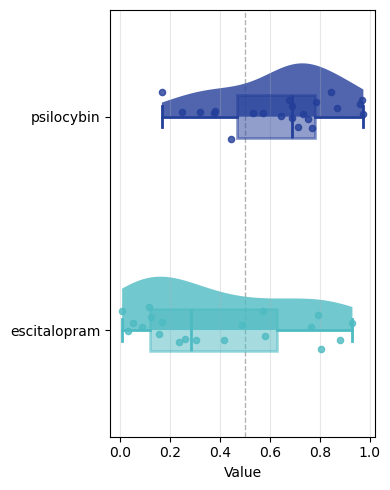

In [87]:
# Load drug-classifier training results
results_dir = os.path.join(output_dir, 'medusa_graphtrip', 'estimate_propensity')
results_file = os.path.join(results_dir, 'prediction_results.csv')
results = aggregate_prediction_results(results_file)

# Plot confusion matrix
save_path = None if not save_figs else os.path.join(fig_subdir, 'confusion_matrix.svg')
plot_confusion_matrix(results['prediction'], results['label'], threshold=0.5, save_path=save_path)

# Plot the AUC curve
save_path = None if not save_figs else os.path.join(fig_subdir, 'auc_curve.svg')
plot_roc_curve(results['prediction'], results['label'], save_path=save_path)

# Raincloud plot with propensity distributions
palette = {'escitalopram': ESCIT, 'psilocybin': PSILO}
symbols = {'escitalopram': 'o', 'psilocybin': 'd'}
save_path = None if not save_figs else os.path.join(fig_subdir, 'propensity_raincloud.svg')
distributions = {
    'escitalopram': results[results['label'] == 0]['prediction'],
    'psilocybin': results[results['label'] == 1]['prediction']}
plot_raincloud(distributions, 
                palette=palette, 
                vline=0.5,
                box_alpha=0.5,
                figsize=(4, 5),
                save_path=save_path)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/medusa_graphtrip/estimate_propensity_wo_QIDS/prediction_results.csv. Loading existing results.


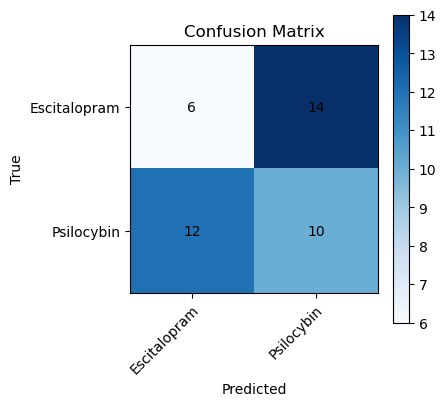

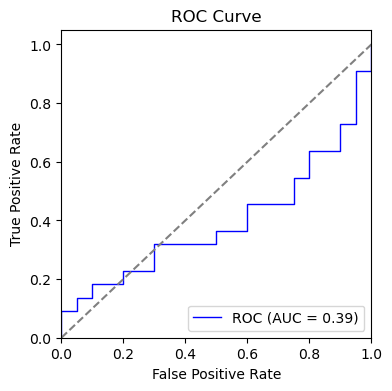

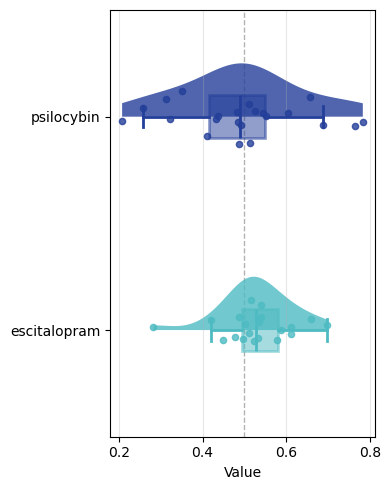

In [88]:
# Load drug-classifier training results
results_dir = os.path.join(output_dir, 'medusa_graphtrip', 'estimate_propensity_wo_QIDS')
results_file = os.path.join(results_dir, 'prediction_results.csv')
results = aggregate_prediction_results(results_file)

# Plot confusion matrix
save_path = None if not save_figs else os.path.join(fig_subdir, 'confusion_matrix_wo_QIDS.svg')
plot_confusion_matrix(results['prediction'], results['label'], threshold=0.5, save_path=save_path)

# Plot the AUC curve
save_path = None if not save_figs else os.path.join(fig_subdir, 'auc_curve_wo_QIDS.svg')
plot_roc_curve(results['prediction'], results['label'], save_path=save_path)

# Raincloud plot with propensity distributions
palette = {'escitalopram': ESCIT, 'psilocybin': PSILO}
symbols = {'escitalopram': 'o', 'psilocybin': 'd'}
save_path = None if not save_figs else os.path.join(fig_subdir, 'propensity_raincloud_wo_QIDS.svg')
distributions = {
    'escitalopram': results[results['label'] == 0]['prediction'],
    'psilocybin': results[results['label'] == 1]['prediction']}
plot_raincloud(distributions, 
                palette=palette, 
                vline=0.5,
                box_alpha=0.5,
                figsize=(4, 5),
                save_path=save_path)

Output file found at /home/hanna/Code/projects/2024_GNNs4DepressionTreatment/graphTRIP/outputs/medusa_graphtrip/permutation_importance/importance_scores_aggregated.csv. Loading existing results.


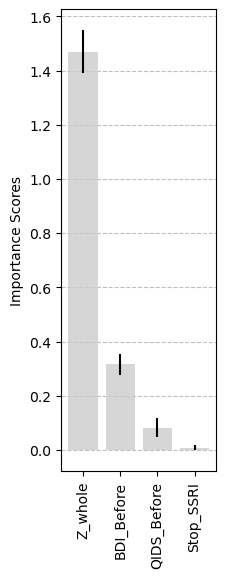

In [89]:
# Permutation Importance
results_file = os.path.join(output_dir, 'medusa_graphtrip', 'permutation_importance', 'importance_scores_aggregated.csv')
results = aggregate_importance_scores(results_file)

# Sort the rows of results by mean importance score
results = results.sort_values(by='mean', ascending=False)
save_path = None if not save_figs else os.path.join(fig_subdir, 'importance_scores_aggregated.svg')
permutation_importance_bar_chart(results, yerr_column='se', color=NEUTRAL, alpha=0.8, save_path=save_path)

## Interpretability Results: CV-fold Model Agreement

In [90]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'cv_model_agreement')
os.makedirs(fig_subdir, exist_ok=True)

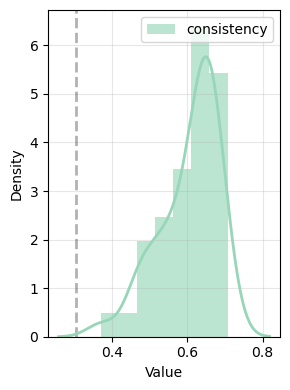

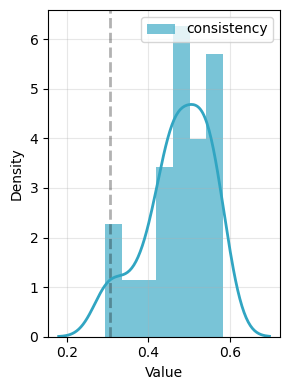

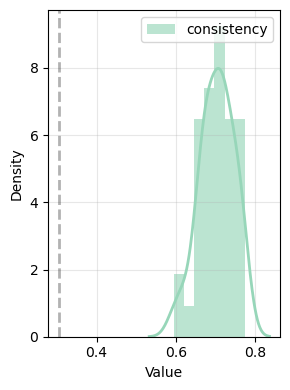

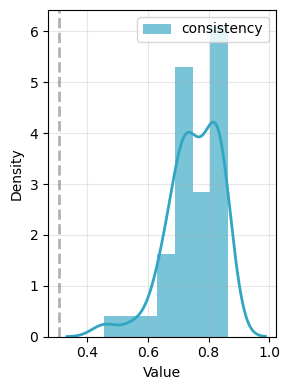

In [91]:
figsize = (3, 4)
alpha = 0.65
colors = plot_colormap_stack('YlGnBu', 10, make_plot=False)

# graphTRIP ------------------------------------------------------------
# Agreement scores for GRAIL and regional attributions of the graphTRIP core model
results_dir = os.path.join(output_dir, 'graphtrip', 'grail', 'posthoc_analysis')
agreement = pd.read_csv(os.path.join(results_dir, 'grail_agreement_scores.csv'))['consistency_score'].values
r_min = min_significant_r(len(agreement))
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphTRIP_grail_agreement_histogram.svg')
plot_histogram({'consistency': agreement}, vline=r_min, save_path=save_path, figsize=figsize, alpha=alpha, palette={'consistency': colors[3]})

# Regional importance agreement
results_dir = os.path.join(output_dir, 'graphtrip', 'regional_attributions', 'posthoc_analysis')
agreement = pd.read_csv(os.path.join(results_dir, 'regional_attributions_agreement_scores.csv'))['consistency_score'].values
r_min = min_significant_r(len(agreement))
save_path = None if not save_figs else os.path.join(fig_subdir, 'graphTRIP_regional_attributions_agreement_histogram.svg')
plot_histogram({'consistency': agreement}, vline=r_min, save_path=save_path, figsize=figsize, alpha=alpha, palette={'consistency': colors[5]})

# x-graphTRIP ------------------------------------------------------------
# Agreement scores for GRAIL and regional attributions of the graphTRIP core model
results_dir = os.path.join(output_dir, 'medusa_graphtrip', 'grail', 'posthoc_analysis')
agreement = pd.read_csv(os.path.join(results_dir, 'grail_agreement_scores.csv'))['consistency_score'].values
r_min = min_significant_r(len(agreement))
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_graphTRIP_grail_agreement_histogram.svg')
plot_histogram({'consistency': agreement}, vline=r_min, save_path=save_path, figsize=figsize, alpha=alpha, palette={'consistency': colors[3]})

# Regional importance agreement
results_dir = os.path.join(output_dir, 'medusa_graphtrip', 'regional_attributions', 'posthoc_analysis')
agreement = pd.read_csv(os.path.join(results_dir, 'regional_attributions_agreement_scores.csv'))['consistency_score'].values
r_min = min_significant_r(len(agreement))
save_path = None if not save_figs else os.path.join(fig_subdir, 'medusa_graphTRIP_regional_attributions_agreement_histogram.svg')
plot_histogram({'consistency': agreement}, vline=r_min, save_path=save_path, figsize=figsize, alpha=alpha, palette={'consistency': colors[5]})


## Understanding GRAIL Biomarkers

In [92]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'GRAIL_biomarkers')
os.makedirs(fig_subdir, exist_ok=True)

#### a. Alignment Captures Univariate Correlations

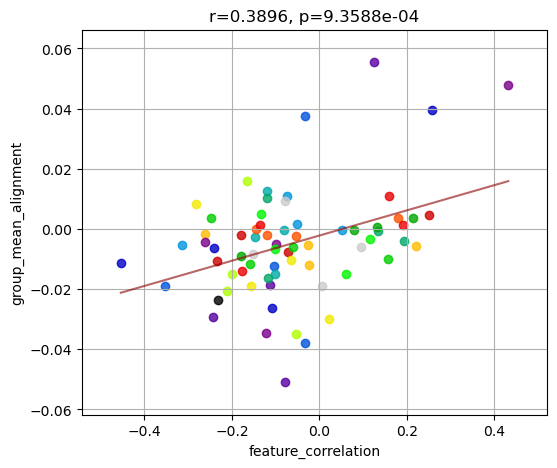

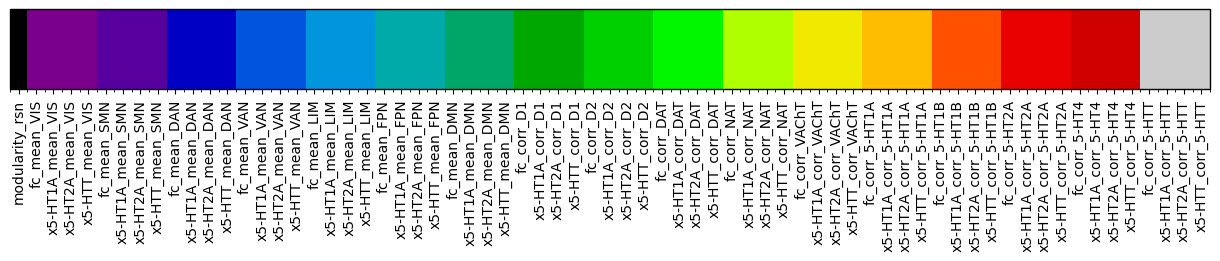

In [93]:
# Load mean alignment results (CV-fold models averaged)
results_dir = os.path.join(output_dir, 'graphtrip', 'grail', 'posthoc_analysis')
mean_alignments = pd.read_csv(os.path.join(results_dir, 'weighted_mean_alignments.csv'))
feature_names = mean_alignments.columns.tolist()

# Load correlations between biomarkers and post-treatment QIDS
results_dir = os.path.join(output_dir, 'graphtrip', 'test_biomarkers')
feature_corrs = pd.read_csv(os.path.join(results_dir, 'feature_correlations.csv'))

# Filter the feature_corrs to include only the features in the mean_alignments
feature_corrs = feature_corrs[feature_corrs['feature'].isin(feature_names)]

# Ensure feature_corrs is ordered according to feature_names
feature_corrs = feature_corrs.set_index('feature').loc[feature_names].reset_index()

# Create a colour palette for each biomarker category
groups = get_groups(feature_names)
groups = [group for group in groups if len(group) > 0]
colors = plot_colormap_stack('nipy_spectral', len(groups), make_plot=False)
palette = {}
for i, group in enumerate(groups):
    color = colors[i]
    for feature in group:
        palette[feature] = color

# Average gradient alignment values across patients to get global values
group_mean_alignments = mean_alignments[feature_names].mean(axis=0)

# Plot group-mean alignment vs feature correlations
save_path = None if not save_figs else os.path.join(fig_subdir, 'group_mean_alignment_vs_feature_corrs.svg')
plot_df = pd.DataFrame({'feature_correlation': feature_corrs['corr'].values, 
                        'group_mean_alignment': group_mean_alignments.values,
                        'feature': feature_names})
regression_scatter2(plot_df, 
                    xcol='feature_correlation', 
                    ycol='group_mean_alignment', 
                    ylim = None,
                    xlim = None,
                    featcol='feature',
                    palette=palette,
                    equal_aspect=False,
                    save_path=save_path)
save_path = None if not save_figs else os.path.join(fig_subdir, 'group_mean_alignment_vs_feature_corrs_legend.svg')
plot_legend(palette, orientation='horizontal', size=(15, 1), label=None, save_path=save_path)

In [94]:
len(feature_names)

69

#### b. graphTRIP Learns More Than Simple Univariate Correlations

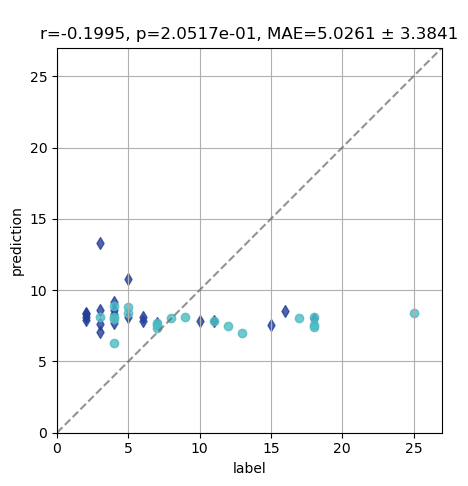

In [95]:
# Check if linear model (Ridge regression) can predict post-treatment QIDS from biomarkers
results = pd.read_csv(os.path.join(output_dir, 'graphtrip', 'test_biomarkers', 'ridge_cv_predict.csv'))
results['Condition'] = conditions
save_path = None if not save_figs else os.path.join(fig_subdir, 'ridge_cv_predict.svg')
true_vs_pred_scatter(results, save_path=save_path)

#### c. All Biomarker Categories

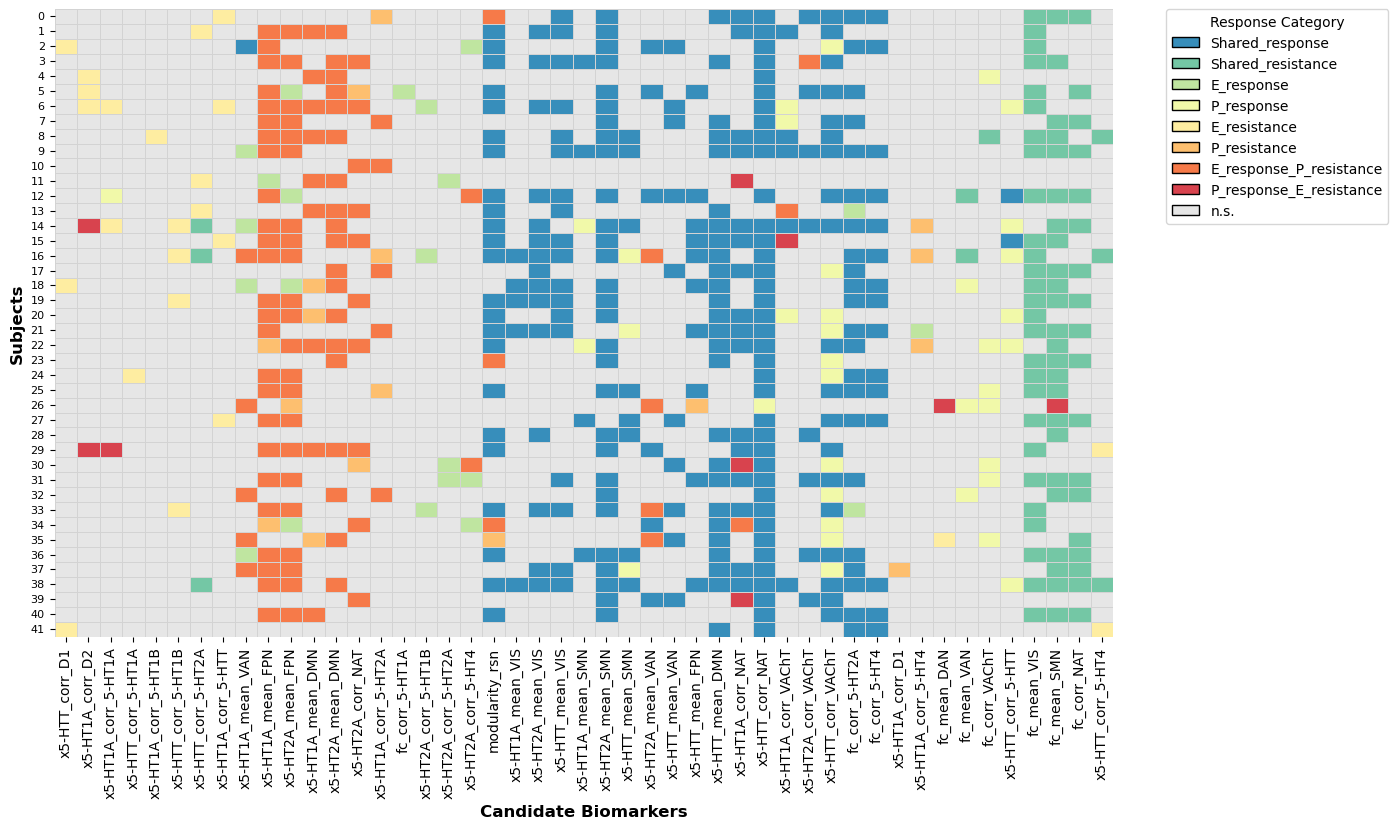

In [96]:
# Make palette for biomarker categories
cats = [
    'Shared_response',
    'Shared_resistance',
    'E_response',
    'P_response',
    'E_resistance',
    'P_resistance',
    'E_response_P_resistance',
    'P_response_E_resistance'
]
colors = sns.color_palette("Spectral_r", len(cats))
palette = {name: color for name, color in zip(cats, colors)}
palette['n.s.'] = (0.9, 0.9, 0.9)

# Plot all biomarkers (except all-n.s.)
biomarker_categories = pd.read_csv(os.path.join(project_root(), 'outputs','biomarker_categories', 'biomarker_categories.csv'))
num_ns = biomarker_categories.apply(lambda col: col.value_counts().get('n.s.', 0))
biomarker_categories = biomarker_categories.loc[:, num_ns < len(biomarker_categories)]

# For each biomarker, get the majority (non-'n.s.') category string label
biomarker_names = list(biomarker_categories.columns)
majority_cat = {}
for biomarker in biomarker_names:
    # Exclude 'n.s.' from the value counts
    counts = biomarker_categories[biomarker].value_counts()
    if 'n.s.' in counts:
        counts = counts.drop('n.s.')
    if not counts.empty:
        majority_cat[biomarker] = counts.idxmax()
    else:
        majority_cat[biomarker] = 'n.s.'

# Sort columns by majority category
unique_cats = list(set(majority_cat.values()))
cat_biomarker_mapping = {cat: [] for cat in unique_cats}
for feat, cat in majority_cat.items():
    cat_biomarker_mapping[cat].append(feat)
sorted_biomarkers = []
for cat in unique_cats:
    sorted_biomarkers.extend(sort_features(cat_biomarker_mapping[cat]))

# Plot
save_path = None if not save_figs else os.path.join(fig_subdir, 'all_biomarker_cats_heatmap.svg')
plot_biomarker_heatmap(biomarker_categories[sorted_biomarkers], palette, save_path=save_path)

#### d. Identified Biomarkers Reflect Both Univariate Relationships and Drug-Biomarker Interactions

In [97]:
# Load biomarker categories and filter the ones with consistant categorization across subjects
biomarker_categories = pd.read_csv(os.path.join(project_root(), 'outputs','biomarker_categories', 'biomarker_categories.csv'))

# Filter biomarkers to those where a majority of subjects has a significant relationship
thresh = 0.5 
num_ns = biomarker_categories.apply(lambda col: col.value_counts().get('n.s.', 0))
biomarker_categories = biomarker_categories.loc[:, num_ns <= int(thresh*len(biomarker_categories))]

biomarker_names = list(biomarker_categories.columns)
majority_cat = {}
for biomarker in biomarker_names:
    counts = biomarker_categories[biomarker].value_counts()
    if 'n.s.' in counts:
        counts = counts.drop('n.s.')
    if not counts.empty:
        majority_cat[biomarker] = counts.idxmax()
    else:
        majority_cat[biomarker] = 'n.s.'

# Sort columns by majority category
unique_cats = sorted(list(set(majority_cat.values())), reverse=True)
cat_biomarker_mapping = {cat: [] for cat in unique_cats}
for feat, cat in majority_cat.items():
    cat_biomarker_mapping[cat].append(feat)
sorted_biomarkers = []
for cat in unique_cats:
    sorted_biomarkers.extend(sort_features(cat_biomarker_mapping[cat]))

In [98]:
# Load candidate biomarker values for all subjects
results_dir = os.path.join(output_dir, 'graphtrip', 'test_biomarkers')
biomarker_values = pd.read_csv(os.path.join(results_dir, 'feature_values.csv'))

# Add drug condition to df
biomarker_values = biomarker_values.sort_values('sub')
biomarker_values['Condition'] = conditions
biomarker_values = biomarker_values.drop(columns=['sub'])

cat_corrs = {'Category': [], 'Biomarker': [], 'Condition': [], 'r': [], 'p': []}
cond_dict = {'P': 1, 'E': -1}
for biomarker in sorted_biomarkers:
    # Columns to include
    df = biomarker_values[[biomarker, 'Condition', 'y']].copy()

    # Compute global pearson correlation
    r, p = pearsonr(df[biomarker], df['y']) 

    # Store results
    cat_corrs['Category'].append(majority_cat[biomarker])
    cat_corrs['Biomarker'].append(biomarker)
    cat_corrs['Condition'].append('Global')
    cat_corrs['r'].append(r)
    cat_corrs['p'].append(p)

    # Compute correlation by condition
    for cond_name, cond_val in cond_dict.items():
        df_cond = df[df['Condition'] == cond_val]
        r, p = pearsonr(df_cond[biomarker], df_cond['y'])

        # Store results
        cat_corrs['Category'].append(majority_cat[biomarker])
        cat_corrs['Biomarker'].append(biomarker)
        cat_corrs['Condition'].append(cond_name)
        cat_corrs['r'].append(r)
        cat_corrs['p'].append(p)

cat_corrs = pd.DataFrame(cat_corrs)
cat_corrs.head()

,Category,Biomarker,Condition,r,p
0,Shared_response,modularity_rsn,Global,-0.231709,0.139808
1,Shared_response,modularity_rsn,P,-0.314420,0.154123
2,Shared_response,modularity_rsn,E,-0.170490,0.472359
3,Shared_response,x5-HT2A_mean_SMN,Global,-0.111921,0.480397
4,Shared_response,x5-HT2A_mean_SMN,P,-0.105171,0.641360


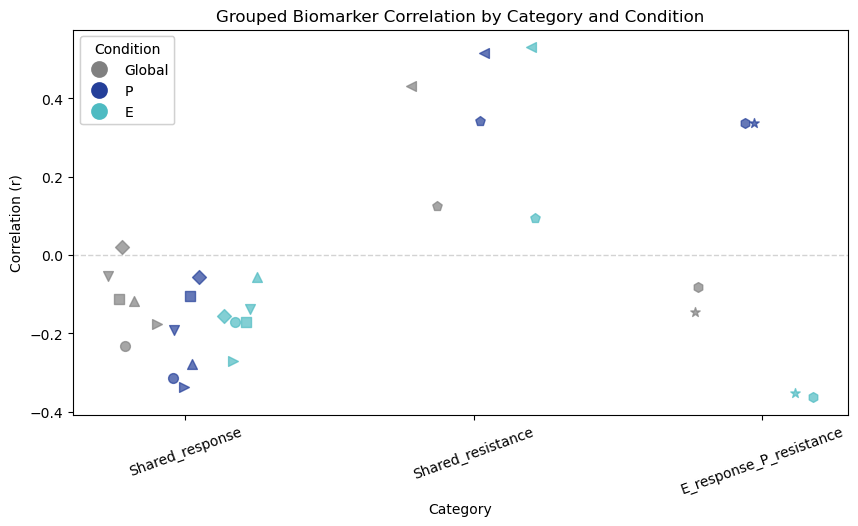

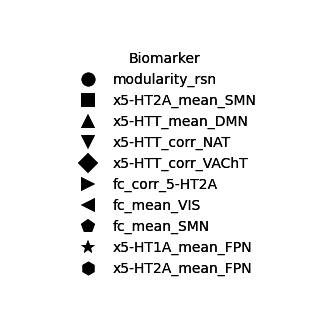

In [99]:
# Prepare values and mapping for plotting
cat_order = list(cat_corrs['Category'].unique())
cond_order = ['Global', 'P', 'E']

# Define unique biomarkers and marker symbols
unique_biomarkers = list(cat_corrs['Biomarker'].unique())
marker_styles = ['o', 's', '^', 'v', 'D', '>', '<', 'p', '*', 'h']  # 10 different markers
biomarker_marker_map = {bm: marker_styles[i % len(marker_styles)] for i, bm in enumerate(unique_biomarkers)}

fig, ax = plt.subplots(figsize=(10, 5))
width = 0.2

# For grouping, use numeric positions
cat_positions = np.arange(len(cat_order))

# Define colors and offsets
cond_offsets = {
    'Global': -width,
    'P': 0,
    'E': width
}
cond_colors = {
    'Global': (0.5, 0.5, 0.5),
    'P': PSILO,
    'E': ESCIT
}

for i, cat in enumerate(cat_order):
    for cnd in cond_order:
        # Filter data for this x-group and condition
        df_group = cat_corrs[(cat_corrs['Category'] == cat) & (cat_corrs['Condition'] == cnd)]
        if df_group.empty:
            continue
        yvals = df_group['r'].values
        biomarkers = df_group['Biomarker'].values

        # Scatter the points, colored by Condition, marker per biomarker
        pos = cat_positions[i] + cond_offsets[cnd]
        jitter = np.random.normal(0, 0.04, size=len(yvals))  # horizontal jitter
        for y, offset, bm in zip(yvals, jitter, biomarkers):
            ax.scatter(
                pos + offset, y,
                color=cond_colors[cnd],
                edgecolor=cond_colors[cnd],
                s=50,
                marker=biomarker_marker_map[bm],
                alpha=0.7,
                zorder=3,
                label=bm  # for manual legend construction
            )

# Add a dashed lightgray horizontal line at y=0
ax.axhline(0, color='lightgray', linestyle='--', linewidth=1)

# Set x-ticks and labels
ax.set_xticks(cat_positions)
ax.set_xticklabels(cat_order, rotation=20)
ax.set_xlabel('Category')
ax.set_ylabel('Correlation (r)')
ax.set_title("Grouped Biomarker Correlation by Category and Condition")

# Custom legend for Condition (color)
legend_patches_cond = [
    plt.Line2D([0], [0], color=cond_colors[cnd], marker='o', linestyle='', markersize=10, label=cnd, markeredgewidth=2)
    for cnd in cond_order
]

leg1 = ax.legend(handles=legend_patches_cond, title="Condition", loc='upper left')
ax.add_artist(leg1)
if save_figs:
    save_path = os.path.join(fig_subdir, 'identified_biomarker_correlations.svg')
    plt.savefig(save_path)
plt.show()

# Plot biomarker legend as a separate figure --------------------------------
fig2, ax2 = plt.subplots(figsize=(4, 4))
ax2.axis('off')
legend_patches_biomarker = [
    plt.Line2D([0], [0], color='k', marker=biomarker_marker_map[bm], linestyle='', markersize=10, 
               label=bm, markerfacecolor='k', markeredgewidth=0)
    for bm in unique_biomarkers]
leg2 = ax2.legend(handles=legend_patches_biomarker, title="Biomarker", loc='center', ncol=1, frameon=False)
ax2.add_artist(leg2)
if save_figs:
    save_path = os.path.join(fig_subdir, 'biomarker_legend.svg')
    plt.savefig(save_path)
plt.show()

## Normative molecular target distributions

In [100]:
# Define output directory
fig_subdir = os.path.join(sm_figure_dir, 'norm_target_maps')
os.makedirs(fig_subdir, exist_ok=True)

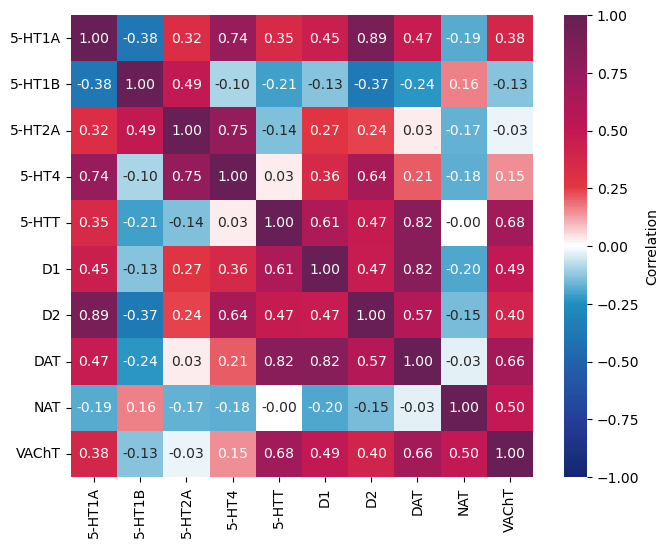

In [101]:
# Load receptor maps
receptors = load_receptor_maps(atlas=data.atlas)

# Plot correlation matrix between receptor distributions
receptor_corr = receptors.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(receptor_corr, 
            cmap=COOLWARM,
            vmin=-1,
            vmax=1,
            square=True,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation'})
if save_figs:
    plt.savefig(os.path.join(fig_subdir, 'receptor_correlations.svg'))